In [409]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import visuals as vs

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

pd.options.display.max_columns = None

## Exploring the Data

In [410]:
data = pd.read_csv("data/prosperLoanData_clean.csv")

The data that I've imported is pre-cleaned, explored, and summarized, as stated in the proposal.  See https://github.com/eskrav/udacity-data-analyst/blob/master/explore-and-summarize/explore-and-summarize.html, for a full numerical and graphical summary of the dataset completed for a previous Udacity project.  

All current loans have already been removed from the dataset, as I am solely interested in historical loans which have already been repaid, or defaulted.  The few historical cancelled loans have been removed from the data, as they do not result in any gain or yield for the lender, and therefore are not of much interest to lenders deciding whether to lend money.

Several new features have already been added to the original data - for example, a simple string and numerical binary factor indicating whether the loan was completed or not; a continuous feature indicating what percent of their investment the lenders in fact earned back on the historical loans, and so forth.  Many of these features will be removed early on, as they are redundant with other features, or of no relevance to the task at hand (e.g., they concern information that principally cannot be available to the lender at the time they are making their decision).

In total, the dataset contains 55084 data points corresponding to individual loans, with 32 continuous and 23 categorical features.  Although the data was cleaned, there is still missing data that was not imputed, and non-normally-distributed continuous features which will need to be transformed.  Continuous features will also need to be scaled.

In [411]:
data.sample(10)

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating.num,ProsperRating.alpha,ProsperScore,ListingCategory.num,BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CurrentlyInGroup,GroupKey,DateCreditPulled,CreditScoreRangeLower,CreditScoreRangeUpper,FirstRecordedCreditLine,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeRange,IncomeVerifiable,StatedMonthlyIncome,LoanKey,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanNumber,LoanOriginalAmount,LoanOriginationDate,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,PercentYield,Completed,Completed.num,CreditScore,CreditHistoryAge
3320,2FF23413191163993DA7E88,275918,2008-02-04,AA,36,Completed,2010-07-27,0.08684,0.0800,0.0800,NaN,NaN,NaN,NaN,NaN,NaN,1,CA,Engineer - Mechanical,Full-time,277.0,False,False,NaN,2008-02-04,800.0,819.0,1994-08-30,11.0,10.0,26.0,5,320.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,10403.0,0.18,44597.0,25.0,1.00,1.0,0.15,"$100,000+",True,11250.000000,842B34137306850240E041D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,73,27537,8000,2008-02-19,Q1 2008,C59C3411877247944434F0C,188.89,9087.16,7999.99,1087.17,0.00,-607.03,0.00,0.00,0.0,1.0,0,0,0.0,130,AA,0.060017,Completed,1,809.5,13.441096
46875,85E83413984323991334060,288056,2008-03-04,A,36,Completed,2009-08-26,0.10124,0.0874,0.0774,NaN,NaN,NaN,NaN,NaN,NaN,1,MI,Other,Retired,317.0,False,False,NaN,2008-03-04,720.0,739.0,1991-07-01,6.0,3.0,13.0,2,12.0,2.0,4.0,0.0,0.0,0.0,1.0,0.0,412.0,0.82,88.0,12.0,1.00,2.0,0.12,"$1-24,999",True,671.000000,0D183414962295951DE22B9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,72,28559,2200,2008-03-18,Q1 2008,2F18341461037712726B55D,69.69,2413.57,2200.00,213.57,-24.44,0.00,0.00,0.00,0.0,1.0,0,0,0.0,107,A,0.085968,Completed,1,729.5,16.687671
33892,ACEB3515620067794130E57,505358,2011-05-04,NaN,60,Completed,2013-04-19,0.27322,0.2499,0.2399,0.2340,0.100,0.1340,3.0,D,4.0,1,UT,Computer Programmer,Employed,100.0,True,False,NaN,2011-05-04,680.0,699.0,1989-12-29,15.0,14.0,53.0,12,1553.0,2.0,8.0,0.0,0.0,0.0,0.0,0.0,60091.0,0.92,4457.0,35.0,0.97,0.0,0.28,"$100,000+",True,8666.666667,20FE362058584821052600A,1.0,6.0,6.0,0.0,0.0,2250.0,2015.71,-55.0,0,NaN,34,49527,10000,2011-05-23,Q2 2011,434634967965160179A9367,293.45,14216.22,10000.00,4216.22,-168.73,0.00,0.00,0.00,0.0,1.0,0,0,0.0,75,D,0.404749,Completed,1,689.5,21.358904
36253,0C653427786463508DC2136,379455,2008-08-07,D,36,Completed,2011-01-18,0.17423,0.1525,0.1425,NaN,NaN,NaN,NaN,NaN,NaN,1,NC,Executive,Full-time,28.0,True,False,NaN,2008-08-07,620.0,639.0,1997-12-09,15.0,13.0,34.0,7,564.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,22640.0,0.95,1448.0,27.0,0.88,0.0,0.28,"$75,000-99,999",True,7083.333333,C920342832300157105470A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,67,35485,7500,2008-08-14,Q3 2008,87F53427338229519B843C3,260.91,9265.72,7499.98,1765.74,-113.83,0.00,0.00,0.00,0.0,1.0,0,0,0.0,168,D,0.220255,Completed,1,629.5,10.668493
28953,0B9833919910945580274AA,147141,2007-06-05,C,36,Completed,2010-06-24,0.26762,0.2600,0.2350,NaN,NaN,NaN,

Having already explored the data in the document linked above, I am immediately removing those features which are irrelevant to the task at hand, or redundant with other features:

The following are internal loan and borrower identifiers, which are no use to the task at hand: `ListingKey`, `ListingNumber`, `LoanKey`, `LoanNumber`, `MemberKey`.

The following concern internal group membership, about which we do not have any further information (further, most loans do not belong to groups): `CurrentlyInGroup`, `GroupKey`.

The following concern information that is not available to the lender at the time they are making the decision of whether to lend money, or is not directly informative about whether the loan is closed, or not: `ClosedDate`, `LP_CustomerPayments`, `LP_CustomerPrincipalPayments`, `LP_InterestandFees`, `LP_ServiceFees`, `LP_CollectionFees`, `LP_GrossPrincipalLoss`, `LP_NetPrincipalLoss`, `LP_NonPrincipalRecoverypayments`, `LoanCurrentDaysDelinquent`, `LoanFirstDefaultedCycleNumber`, `LoanMonthsSinceOrigination`, `PercentYield`.

The following are redundant with the `Rating` feature, which combines pre- and post-2009 Prosper rating schemes: `ProsperRating.num`, `ProsperRating.alpha`, `CreditGrade`.

The following are redundant with the label of interest (`Completed.num`), which indicates whether the loan was repaid in full, or defaulted: `LoanStatus`, `Completed`.  The following are redundant with `CreditScore`: `CreditScoreRangeLower`, `CreditScoreRangeUpper`.  The following is redundant with the loan origination date: `LoanOriginationQuarter`.  The Following is redundant with the borrower rate: `BorrowerAPR`.  The following is redundant with monthly income, which as a continuous feature is more easily interpretable: `IncomeRange`.  The following is redundant with age of credit history at the time the loan was originated: `FirstRecordedCreditLine`.

Almost all loans are completely funded (`PercentFunded`).

In [412]:
redundant_irrelevant = ["ListingKey", "ListingNumber", "LoanKey", "LoanNumber", "LoanStatus", "ClosedDate",
                       "ProsperRating.num", "ProsperRating.alpha", "CreditScoreRangeLower", "CreditScoreRangeUpper",
                       "LoanOriginationQuarter", "MemberKey", "LP_CustomerPayments", "LP_CustomerPrincipalPayments",
                       "LP_InterestandFees", "LP_ServiceFees", "LP_CollectionFees", "LP_GrossPrincipalLoss",
                       "LP_NetPrincipalLoss", "LP_NonPrincipalRecoverypayments", "PercentFunded", "PercentYield",
                       "Completed", "LoanCurrentDaysDelinquent", "LoanFirstDefaultedCycleNumber", 
                       "LoanMonthsSinceOrigination", "BorrowerAPR", "CurrentlyInGroup", "GroupKey", "IncomeRange",
                       "CreditGrade", "FirstRecordedCreditLine"]

data.drop(redundant_irrelevant, axis=1, inplace=True)

In [413]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55084 entries, 0 to 55083
Data columns (total 55 columns):
ListingCreationDate                    55084 non-null object
Term                                   55084 non-null int64
BorrowerRate                           55084 non-null float64
LenderYield                            55084 non-null float64
EstimatedEffectiveYield                26005 non-null float64
EstimatedLoss                          26005 non-null float64
EstimatedReturn                        26005 non-null float64
ProsperScore                           26005 non-null float64
ListingCategory.num                    55084 non-null int64
BorrowerState                          49572 non-null object
Occupation                             52819 non-null object
EmploymentStatus                       52832 non-null object
EmploymentStatusDuration               47473 non-null float64
IsBorrowerHomeowner                    55084 non-null bool
DateCreditPulled                  

First, I convert the dates to continuous timestamps, as the methods I use are not able to handle datetime objects:

In [414]:
data['ListingCreationDate'] = pd.to_datetime(data['ListingCreationDate']).astype(np.int64)
data['DateCreditPulled'] = pd.to_datetime(data['DateCreditPulled']).astype(np.int64)
data['LoanOriginationDate'] = pd.to_datetime(data['LoanOriginationDate']).astype(np.int64)

Below, I examine features with null values, and infer from existing values if they can/should be imputed (e.g., an `NA` may represent a 0 for some features, if 0's are not generally coded, but would be expected to show up):

In [415]:
data.TotalProsperLoans.value_counts()

1.0    7928
2.0    1954
3.0     486
4.0     118
5.0      37
6.0      10
7.0       5
0.0       1
Name: TotalProsperLoans, dtype: int64

In [416]:
data.describe()

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatusDuration,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Completed.num,CreditScore,CreditHistoryAge
count,5.508400e+04,55084.000000,55084.000000,55084.000000,26005.000000,26005.000000,26005.000000,26005.000000,55084.000000,47473.000000,5.508400e+04,47484.000000,47484.000000,54388.000000,55084.000000,55084.000000,54388.000000,53929.000000,54388.000000,47466.000000,54097.000000,54388.000000,47484.000000,4.748400e+04,47484.000000,47544.000000,47544.000000,47544.000000,47544.000000,50854.000000,55084.000000,10539.000000,10539.000000,10539.000000,10539.000000,10539.000000,10539.000000,10539.000000,10442.000000,55084.000000,5.508400e+04,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,54494.000000,54388.000000
mean,1.247579e+18,36.942851,0.200423,0.190292,0.176231,0.093795,0.107539,6.265987,2.407578,80.895878,1.247556e+18,9.568634,8.337861,25.276164,6.078389,325.307403,2.051850,7.166608,0.906229,1050.814962,4.571658,0.331029,0.023713,1.568936e+04,0.530446,10844.170411,21.786808,0.856399,0.909326,0.289866,5054.723018,1.332764,20.078850,19.486099,0.544074,0.048202,7104.678315,2332.674796,1.146811,6261.892746,1.248817e+18,223.729882,0.089391,0.046111,33.589037,104.897665,0.691199,681.246247,14.670098
std,6.899523e+16,7.333480,0.081291,0.080726,0.081519,0.055062,0.038377,2.319612,3.397823,84.669661,6.921332e+16,5.582143,4.985417,14.268205,4.528996,448.839320,3.147988,8.214843,2.595972,6676.861621,10.689471,0.790619,0.180400,3.401072e+04,0.350780,21869.026283,12.456163,0.174057,1.240458,0.736738,5711.051112,0.676027,15.871918,15.466862,2.151244,0.509123,6395.297342,3285.130455,50.913387,5217.758039,6.904301e+16,185.727523,0.453767,0.327691,422.191018,108.893346,0.462003,81.908137,7.554535
min,1.131494e+18,12.000000,0.000000,-0.010000,-0.182700,0.004900,-0.182700,1.000000,0.000000,0.000000,1.131494e+18,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-194.000000,1000.000000,1.132013e+18,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,9.500000,0.019178
25%,1.186963e+18,36.000000,0.135000,0.125000,0.110600,0.052000,0.078000,5.000000,0.000000,21.000000,1.186358e+18,6.000000,5.000000,15.000000,3.000000,60.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.614000e+03,0.210000,506.000000,13.000000,0.770000,0.000000,0.130000,2810.604167,1.000000,9.000000,9.000000,0.000000,0.000000,3000.000000,0.000000,-32.000000,2600.000000,1.187914e+18,98.290000,0.000000,0.000000,0.000000,31.000000,0.000000,649.500000,9.416438
50%,1.219277e+18,36.000000,0.194500,0.182550,0.171500,0.098000,0.114400,6.000000,1.000000,52.000000,1.219190e+18,9.000000,8.000000,23.000000,5.000000,183.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.073000e+03,0.560000,3245.500000,20.000000,0.920000,1.000000,0.200000,4166.666667,1.000000,15.000000,14.000000,0.000000,0.000000,5000.000000,1098.020000,0.000000,4500.000000,1.220

### Data Imputation

`EstimatedEffectiveYield` was a measure not available prior to mid-2009.  However, it measures the borrower rate minus expected fees, which can be imputed.  Given the data is not normally distributed (which will be examined further below), I will impute missing data with the median difference between borrower rate and estimated effective yield, as implemented in https://www.kaggle.com/jschnessl/prosper-analysis/notebook:

In [417]:
data[data.EstimatedEffectiveYield.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
26963,1157241600000000000,36,0.1500,0.1450,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,False,1157155200000000000,NaN,NaN,7.0,7,20.0,3.0,8.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,True,9583.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8500,1158537600000000000,294.66,0,0,0.0,93,C,0,669.5,0.846575
27447,1177113600000000000,36,0.2700,0.2600,NaN,NaN,NaN,NaN,0,TX,Analyst,Full-time,8.0,False,1176681600000000000,2.0,2.0,14.0,0,0.0,4.0,11.0,11.0,2712.0,0.0,0.0,0.0,0.0,0.00,0.0,2.0,0.08,1.0,0.10,True,2367.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1177632000000000000,40.83,1,0,0.0,16,HR,0,529.5,3.589041
41568,1176422400000000000,36,0.0100,0.0000,NaN,NaN,NaN,NaN,0,MA,Teacher,Part-time,18.0,False,1176422400000000000,5.0,5.0,13.0,3,107.0,2.0,5.0,4.0,2897.0,18.0,0.0,0.0,259.0,0.12,1841.0,10.0,0.40,0.0,10.01,True,34.583333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6001,1177545600000000000,153.81,0,0,0.0,1,E,1,589.5,6.506849
14264,1156464000000000000,36,0.0900,0.0850,NaN,NaN,NaN,NaN,0,KS,Teacher,Not available,NaN,True,1156464000000000000,NaN,NaN,22.0,7,830.0,0.0,2.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.26,True,3382.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1200,1156896000000000000,38.16,0,0,0.0,10,AA,1,769.5,17.449315
14415,1173398400000000000,36,0.1885,0.1685,NaN,NaN,NaN,NaN,0,CA,Food Service Management,Full-time,238.0,True,1172534400000000000,32.0,27.0,72.0,25,1670.0,5.0,21.0,0.0,0.0,0.0,0.0,0.0,87390.0,0.75,28492.0,67.0,1.00,0.0,0.48,True,6750.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19900,1174608000000000000,727.95,0,0,0.0,229,C,0,649.5,19.783562


In [418]:
estimated_fees = (data["BorrowerRate"] - data["EstimatedEffectiveYield"]).median()
data["EstimatedEffectiveYield"].fillna(data["BorrowerRate"] - estimated_fees, inplace=True)
data["EstimatedEffectiveYield"].isnull().sum()

0

It's unclear how `EstimatedLoss` is computed.  Given the potential importance of this feature, and the difficulty in imputing it -- as well as the clear dependance on other features, such as risk measures -- I will not attempt to impute this feature, and will look for an algorithm robust to missing values, or simply leave this feature out.  The other potential solution would be to analyze pre-mid-2009 and post-mid-2009 datasets separately.  Ideally, one may want to do linear regression to infer likely values, but that is beyond the scope of this project.

In [419]:
data[data.EstimatedLoss.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
46521,1175472000000000000,36,0.200,0.19,0.1764,NaN,NaN,NaN,0,OK,Clerical,Part-time,4.0,False,1175472000000000000,11.0,9.0,26.0,3,113.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,6892.0,1.00,134.0,22.0,0.90,1.0,1.00,True,936.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990,1176681600000000000,73.96,0,0,0.0,29,D,0,629.5,6.876712
38669,1185926400000000000,36,0.145,0.13,0.1214,NaN,NaN,NaN,0,WI,Professor,Full-time,1.0,False,1185753600000000000,4.0,4.0,31.0,3,31.0,8.0,14.0,0.0,0.0,0.0,1.0,1.0,1590.0,0.22,5510.0,18.0,0.94,2.0,0.15,True,3666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6100,1186617600000000000,206.79,0,0,0.0,73,B,1,689.5,19.498630
35553,1182211200000000000,36,0.140,0.13,0.1164,NaN,NaN,NaN,0,NaN,Medical Technician,Full-time,89.0,False,1180915200000000000,5.0,4.0,25.0,3,69.0,6.0,22.0,0.0,0.0,12.0,1.0,0.0,1318.0,0.58,950.0,20.0,0.76,1.0,0.05,True,5416.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2551,1182902400000000000,87.19,0,0,0.0,124,D,1,609.5,9.123288
37131,1173139200000000000,36,0.200,0.19,0.1764,NaN,NaN,NaN,0,NaN,Military Enlisted,Full-time,29.0,False,1173139200000000000,7.0,4.0,19.0,2,0.0,4.0,19.0,0.0,0.0,10.0,0.0,0.0,400.0,0.00,100.0,13.0,0.76,0.0,0.10,True,2063.416667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2400,1173398400000000000,89.19,0,0,0.0,33,D,1,629.5,13.542466
962,1184112000000000000,36,0.210,0.20,0.1864,NaN,NaN,NaN,0,CA,Computer Programmer,Full-time,120.0,False,1184112000000000000,21.0,16.0,42.0,14,585.0,8.0,21.0,0.0,0.0,0.0,0.0,0.0,15771.0,0.51,10512.0,41.0,0.97,1.0,0.24,True,8041.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1184716800000000000,188.38,0,0,0.0,57,D,1,609.5,10.827397


`EstimatedReturn` is the difference between estimated yield and estimated loss, and cannot be computed without the latter.  I will treat this feature similarly to `EstimatedLoss`.

In [420]:
data[data.EstimatedReturn.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
26388,1147219200000000000,36,0.2375,0.2325,0.2139,NaN,NaN,NaN,0,MO,NaN,NaN,NaN,False,1147219200000000000,NaN,NaN,35.0,0,0.0,7.0,NaN,8.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09000,True,7000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1147996800000000000,78.20,0,0,0.0,23,HR,0,509.5,7.120548
36065,1206576000000000000,36,0.1860,0.1760,0.1624,NaN,NaN,NaN,1,IL,Nurse (LPN),Full-time,5.0,True,1206576000000000000,7.0,6.0,34.0,3,74.0,8.0,30.0,1.0,309.0,0.0,0.0,0.0,789.0,0.96,18.0,27.0,0.86,1.0,0.09000,True,2944.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1208217600000000000,109.36,0,0,0.0,89,C,0,669.5,13.871233
946,1144022400000000000,36,0.0840,0.0790,0.0604,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,False,1144022400000000000,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.14752,True,3399.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1145232000000000000,31.52,0,0,0.0,28,A,1,NaN,NaN
17635,1212019200000000000,36,0.2820,0.2720,0.2584,NaN,NaN,NaN,4,MN,Skilled Labor,Full-time,14.0,False,1210032000000000000,4.0,3.0,11.0,3,55.0,1.0,2.0,4.0,4751.0,1.0,1.0,0.0,911.0,0.68,414.0,6.0,0.55,1.0,0.03000,True,3750.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1213056000000000000,41.47,0,0,0.0,26,HR,1,529.5,10.109589
38590,1208995200000000000,36,0.3376,0.3276,0.3140,NaN,NaN,NaN,4,MI,Professional,Full-time,95.0,False,1207008000000000000,2.0,2.0,7.0,0,0.0,1.0,4.0,2.0,161.0,13.0,1.0,1.0,0.0,0.00,0.0,5.0,0.50,2.0,0.38000,True,1541.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1209513600000000000,44.54,1,0,0.0,4,D,0,629.5,8.920548


`ProsperScore` is a post-2009 measure.  In my exploratory analysis, it seemed that it might not be entirely redundant with the various Prosper ratings.  I don't believe there is any good way to impute this feature, and will either omit it from the model, or use a model robust to missing values.

In [421]:
data[data.ProsperScore.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
22156,1206921600000000000,36,0.1420,0.1320,0.1184,NaN,NaN,NaN,4,IN,Retail Management,Full-time,215.0,True,1205107200000000000,16.0,14.0,23.0,11,970.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,80034.0,0.83,14417.0,21.0,0.95,2.0,0.26000,True,8750.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1207526400000000000,171.37,0,0,0.0,110,B,0,689.5,8.238356
18506,1213488000000000000,36,0.1200,0.1100,0.0964,NaN,NaN,NaN,1,NY,Professional,Full-time,51.0,False,1213315200000000000,7.0,4.0,12.0,3,178.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,3413.0,0.00,0.0,9.0,0.55,0.0,0.14000,True,6250.000000,1.0,16.0,16.0,0.0,0.0,13000.0,6660.39,0.0,6200,1214265600000000000,205.93,0,0,0.0,218,C,1,669.5,13.969863
8019,1192320000000000000,36,0.1724,0.1624,0.1488,NaN,NaN,NaN,0,KY,Clerical,Full-time,17.0,True,1190937600000000000,16.0,10.0,29.0,8,527.0,1.0,14.0,0.0,0.0,2.0,0.0,0.0,13735.0,0.72,4410.0,24.0,0.75,1.0,0.23000,True,4583.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15200,1193356800000000000,543.74,1,1,500.0,357,D,1,629.5,20.978082
25040,1161648000000000000,36,0.1955,0.1905,0.1719,NaN,NaN,NaN,0,WA,Professional,Not available,NaN,False,1160179200000000000,NaN,NaN,36.0,11,381.0,2.0,5.0,4.0,NaN,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.66000,True,3416.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9546,1162944000000000000,352.58,0,0,0.0,178,C,1,649.5,10.068493
50015,1146441600000000000,36,0.1172,0.1110,0.0936,NaN,NaN,NaN,0,CT,NaN,NaN,NaN,True,1146441600000000000,NaN,NaN,21.0,0,0.0,4.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.19946,True,16666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1146700800000000000,162.42,0,0,0.0,48,A,1,729.5,14.339726


`BorrowerState` cannot be imputed.  Unknown values can be labeled as such; however, given the number of feature levels, and no clear expectations for how this feature will affect reliability, the states may need to be grouped into more meaningful regions or categories prior to use.  I leave this for future work.

In [422]:
data[data.BorrowerState.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
26022,1164499200000000000,36,0.1795,0.1745,0.1559,NaN,NaN,NaN,0,NaN,Clerical,Not available,NaN,False,1164499200000000000,NaN,NaN,11.0,1,20.0,6.0,17.0,2.0,NaN,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.21000,True,2500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1165881600000000000,72.25,0,0,0.0,16,HR,0,509.5,3.024658
26385,1169510400000000000,36,0.1700,0.1650,0.1464,NaN,NaN,NaN,0,NaN,Retail Management,Not available,NaN,False,1169164800000000000,NaN,NaN,40.0,10,113.0,1.0,12.0,1.0,NaN,14.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.21000,True,6250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5300,1170201600000000000,188.96,0,0,0.0,69,C,0,649.5,13.263014
28979,1146009600000000000,36,0.1895,0.1845,0.1659,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,True,1146009600000000000,NaN,NaN,23.0,0,0.0,2.0,NaN,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.15421,True,4333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1146700800000000000,70.99,0,0,0.0,33,D,1,629.5,19.317808
21450,1174348800000000000,36,0.2300,0.2200,0.2064,NaN,NaN,NaN,0,NaN,Professional,Full-time,10.0,True,1174262400000000000,7.0,7.0,9.0,4,341.0,6.0,30.0,1.0,45.0,0.0,0.0,0.0,8148.0,0.67,132.0,9.0,0.77,1.0,0.15000,True,7916.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25000,1175472000000000000,967.74,0,0,0.0,216,D,0,629.5,4.090411
13503,1151539200000000000,36,0.2075,0.2025,0.1839,NaN,NaN,NaN,0,NaN,Other,Not available,NaN,False,1151539200000000000,NaN,NaN,7.0,5,332.0,0.0,0.0,1.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.28000,True,1333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1152057600000000000,37.55,0,0,0.0,13,C,1,649.5,9.263014


In [423]:
data.drop(columns="BorrowerState", axis=1, inplace=True)

`Occupation` cannot be imputed.  Unknown values can be labeled as such, but as with state, would need to be grouped meaningfully (e.g. by working class, minimally) to be informative.  I likewise leave this for future work, and drop this feature from the dataset.

In [424]:
data[data.Occupation.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
46428,1148860800000000000,36,0.20,0.1950,0.1764,NaN,NaN,NaN,0,NaN,NaN,NaN,False,1148860800000000000,NaN,NaN,7.0,0,0.0,1.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.16000,True,1666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1150156800000000000,185.82,0,0,0.0,122,E,0,589.5,3.693151
48161,1147910400000000000,36,0.07,0.0650,0.0464,NaN,NaN,NaN,0,NaN,NaN,NaN,False,1147910400000000000,NaN,NaN,14.0,0,0.0,1.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.12000,True,4166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5750,1148256000000000000,177.54,0,0,0.0,6,AA,1,829.5,30.397260
21719,1141776000000000000,36,0.20,0.1825,0.1764,NaN,NaN,NaN,0,NaN,NaN,NaN,False,1139961600000000000,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.19827,True,2416.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1142294400000000000,37.16,0,0,0.0,8,HR,1,NaN,NaN
14831,1156291200000000000,36,0.22,0.2150,0.1964,NaN,NaN,NaN,0,NaN,NaN,NaN,False,1156291200000000000,NaN,NaN,10.0,5,116.0,2.0,12.0,0.0,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.22000,True,2666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6001,1158105600000000000,229.18,0,0,0.0,51,E,1,549.5,10.939726
26642,1158710400000000000,36,0.27,0.2650,0.2464,NaN,NaN,NaN,0,NaN,NaN,NaN,False,1157673600000000000,NaN,NaN,22.0,0,0.0,6.0,27.0,17.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10000,True,3333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,1159142400000000000,61.24,0,0,0.0,9,HR,0,529.5,10.186301


In [425]:
data.drop(columns="Occupation", axis=1, inplace=True)

`EmploymentStatus` cannot be imputed.  Unknown values will be labeled as such.

In [426]:
data[data.EmploymentStatus.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
28585,1143676800000000000,36,0.3570,0.3520,0.3334,NaN,NaN,NaN,0,NaN,NaN,False,1143504000000000000,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04185,True,2500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1144022400000000000,45.63,0,0,0.0,12,HR,1,NaN,NaN
12831,1149552000000000000,36,0.2475,0.2425,0.2239,NaN,NaN,NaN,0,NaN,NaN,True,1148947200000000000,NaN,NaN,27.0,1,0.0,5.0,33.0,9.0,NaN,30.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01000,True,6250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1200,1149811200000000000,47.55,0,0,0.0,11,HR,0,509.5,19.112329
17865,1141776000000000000,36,0.1400,0.1350,0.1164,NaN,NaN,NaN,0,NaN,NaN,False,1141776000000000000,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.17742,True,4000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15000,1143072000000000000,512.66,0,0,0.0,158,C,1,NaN,NaN
24049,1154131200000000000,36,0.2900,0.2850,0.2664,NaN,NaN,NaN,0,NaN,NaN,False,1154131200000000000,NaN,NaN,20.0,4,108.0,2.0,7.0,15.0,NaN,15.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04000,True,3333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1154563200000000000,41.91,0,0,0.0,14,HR,0,469.5,11.402740
9798,1150675200000000000,36,0.2875,0.2700,0.2639,NaN,NaN,NaN,0,NaN,NaN,True,1150675200000000000,NaN,NaN,16.0,8,75.0,3.0,5.0,4.0,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.15000,True,3500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1152489600000000000,125.31,0,0,0.0,35,HR,0,489.5,7.087671


In [427]:
data["EmploymentStatus"].fillna("Unknown", inplace=True)
data["EmploymentStatus"].isnull().sum()

0

I will impute `EmploymentStatusDuration` with the median value for this variable.  I would also consider dropping all missing rows, potentially, expecially if there were also missing values in other difficult-to-impute features.

In [428]:
data[data.EmploymentStatusDuration.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
45757,1154044800000000000,36,0.1141,0.1091,0.0905,NaN,NaN,NaN,0,Not available,NaN,False,1154044800000000000,NaN,NaN,22.0,7,164.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.15000,True,7500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12000,1154908800000000000,395.20,0,0,0.0,229,A,1,749.5,11.915068
27397,1163203200000000000,36,0.2400,0.2150,0.2164,NaN,NaN,NaN,0,Not available,NaN,False,1162339200000000000,NaN,NaN,21.0,1,27.0,2.0,14.0,9.0,NaN,26.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04000,True,2250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,1164067200000000000,58.85,0,0,0.0,7,HR,0,489.5,10.032877
52260,1165536000000000000,36,0.1785,0.1635,0.1549,NaN,NaN,NaN,0,Unknown,NaN,False,1165017600000000000,NaN,NaN,25.0,2,25.0,2.0,11.0,1.0,NaN,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.16000,True,3750.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4500,1167350400000000000,162.35,0,0,0.0,87,D,1,609.5,9.539726
16078,1165017600000000000,36,0.0770,0.0720,0.0534,NaN,NaN,NaN,0,Not available,NaN,True,1165017600000000000,NaN,NaN,32.0,15,1117.0,2.0,16.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.14000,True,9329.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1166140800000000000,155.99,0,0,0.0,92,AA,1,809.5,20.630137
53768,1141084800000000000,36,0.2400,0.2225,0.2164,NaN,NaN,NaN,0,Unknown,NaN,False,1140566400000000000,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07821,True,8166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1141603200000000000,117.70,0,0,0.0,20,E,1,NaN,NaN


In [429]:
median_employment_status_duration = data["EmploymentStatusDuration"].median()
data["EmploymentStatusDuration"].fillna(median_employment_status_duration, inplace=True)
data["EmploymentStatusDuration"].isnull().sum()

0

It's unclear what the right course of action here is, but I will impute missing `CurrentCreditLines` with median values.

In [430]:
data[data.CurrentCreditLines.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
50996,1161734400000000000,36,0.2800,0.275,0.2564,NaN,NaN,NaN,0,Not available,52.0,True,1161302400000000000,NaN,NaN,21.0,2,15.0,6.0,10.0,7.0,NaN,23.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.16,True,3941.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1162252800000000000,124.09,0,0,0.0,25,E,0,549.5,23.071233
20203,1165363200000000000,36,0.1500,0.145,0.1264,NaN,NaN,NaN,0,Not available,52.0,False,1165363200000000000,NaN,NaN,7.0,5,116.0,1.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06,True,3750.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3500,1166486400000000000,121.33,0,0,0.0,48,HR,0,529.5,4.180822
33568,1148515200000000000,36,0.1575,0.140,0.1339,NaN,NaN,NaN,0,Unknown,52.0,False,1148515200000000000,NaN,NaN,2.0,0,0.0,0.0,NaN,0.0,NaN,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,True,5666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,1148947200000000000,52.55,0,0,0.0,4,NC,1,9.5,4.594521
50206,1161993600000000000,36,0.2000,0.190,0.1764,NaN,NaN,NaN,0,Not available,52.0,True,1161475200000000000,NaN,NaN,48.0,4,35.0,10.0,25.0,1.0,NaN,26.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.17,True,16666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15000,1162857600000000000,366.71,0,0,0.0,143,C,1,669.5,13.378082
51054,1166572800000000000,36,0.1250,0.120,0.1014,NaN,NaN,NaN,0,Not available,52.0,True,1166486400000000000,NaN,NaN,17.0,3,465.0,5.0,19.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.23,True,6000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000,1168473600000000000,334.54,0,0,0.0,255,B,1,689.5,5.632877


In [431]:
median_credit_lines = data["CurrentCreditLines"].median()
data["CurrentCreditLines"].fillna(median_credit_lines, inplace=True)
data["CurrentCreditLines"].isnull().sum()

0

Same for `OpenCreditLines`.

In [432]:
data[data.OpenCreditLines.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
30059,1168473600000000000,36,0.200,0.195,0.1764,NaN,NaN,NaN,0,Not available,52.0,False,1168473600000000000,9.0,NaN,10.0,8,396.0,0.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.15,True,3333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1168992000000000000,111.49,0,0,0.0,38,D,1,629.5,7.424658
53191,1164585600000000000,36,0.270,0.265,0.2464,NaN,NaN,NaN,0,Not available,52.0,False,1162857600000000000,9.0,NaN,11.0,4,205.0,13.0,32.0,4.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.59,True,270.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2550,1165449600000000000,104.10,0,0,0.0,32,HR,0,489.5,7.621918
53165,1164412800000000000,36,0.080,0.075,0.0564,NaN,NaN,NaN,0,Not available,52.0,True,1162857600000000000,9.0,NaN,6.0,4,26.0,2.0,5.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05,True,1333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,1165276800000000000,47.00,0,0,0.0,60,A,1,749.5,2.939726
32553,1167782400000000000,36,0.200,0.195,0.1764,NaN,NaN,NaN,0,Not available,52.0,False,1167782400000000000,9.0,NaN,34.0,2,58.0,5.0,9.0,8.0,NaN,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.32,True,1800.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1168992000000000000,37.16,0,0,0.0,10,E,0,589.5,10.432877
44246,1170115200000000000,36,0.175,0.155,0.1514,NaN,NaN,NaN,0,Not available,52.0,False,1170028800000000000,9.0,NaN,55.0,7,190.0,3.0,12.0,3.0,NaN,22.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.18,True,4840.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2550,1170892800000000000,91.55,0,0,0.0,129,D,0,609.5,16.843836


In [433]:
median_open_credit_lines = data["OpenCreditLines"].median()
data["OpenCreditLines"].fillna(median_open_credit_lines, inplace=True)
data["OpenCreditLines"].isnull().sum()

0

Same for `TotalCreditLinespast7years`.

In [434]:
data[data.TotalCreditLinespast7years.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
30971,1139788800000000000,36,0.0800,0.0750,0.0564,NaN,NaN,NaN,0,Unknown,52.0,False,1139788800000000000,9.0,8.0,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.11119,True,13083.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1140566400000000000,74.52,0,0,0.0,9,AA,0,NaN,NaN
50481,1142553600000000000,36,0.2475,0.2300,0.2239,NaN,NaN,NaN,0,Unknown,52.0,False,1140998400000000000,9.0,8.0,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06154,True,3166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1143504000000000000,118.88,0,0,0.0,20,HR,0,NaN,NaN
32007,1141516800000000000,36,0.2000,0.1950,0.1764,NaN,NaN,NaN,0,Unknown,52.0,False,1141257600000000000,9.0,8.0,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04495,True,1916.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1142899200000000000,37.16,0,0,0.0,11,HR,1,NaN,NaN
22611,1144540800000000000,36,0.1225,0.1125,0.0989,NaN,NaN,NaN,0,Unknown,52.0,False,1143849600000000000,9.0,8.0,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13417,True,2916.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7000,1145577600000000000,230.81,0,0,0.0,80,B,1,NaN,NaN
36734,1138147200000000000,36,0.1400,0.1350,0.1164,NaN,NaN,NaN,0,Unknown,52.0,False,1134259200000000000,9.0,8.0,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.12133,True,5833.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1138320000000000000,170.89,0,0,0.0,4,HR,0,NaN,NaN


In [435]:
median_7_credit_lines = data["TotalCreditLinespast7years"].median()
data["TotalCreditLinespast7years"].fillna(median_7_credit_lines, inplace=True)
data["TotalCreditLinespast7years"].isnull().sum()

0

I will impute missing values in `InquiriesLast6Months` with median values.

In [436]:
data[data.InquiriesLast6Months.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
38980,1139961600000000000,36,0.0997,0.0935,0.0761,NaN,NaN,NaN,0,Unknown,52.0,False,1139961600000000000,9.0,8.0,23.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.11383,True,7083.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25000,1140652800000000000,782.93,0,0,0.0,44,A,1,NaN,NaN
29762,1143849600000000000,36,0.1500,0.1425,0.1264,NaN,NaN,NaN,0,Unknown,52.0,False,1143849600000000000,9.0,8.0,23.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25400,True,8333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000,1144281600000000000,346.65,0,0,0.0,57,A,0,NaN,NaN
6370,1140652800000000000,36,0.1490,0.1440,0.1254,NaN,NaN,NaN,0,Unknown,52.0,False,1140652800000000000,9.0,8.0,23.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01539,True,2250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1141603200000000000,34.62,0,0,0.0,14,HR,0,NaN,NaN
49775,1161216000000000000,36,0.2300,0.2250,0.2064,NaN,NaN,NaN,0,Not available,52.0,False,1160092800000000000,9.0,8.0,23.0,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1161907200000000000,38.71,0,0,0.0,13,NC,0,9.5,NaN
36799,1141689600000000000,36,0.0875,0.0825,0.0639,NaN,NaN,NaN,0,Unknown,52.0,False,1140998400000000000,9.0,8.0,23.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09265,True,3750.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1142208000000000000,158.42,0,0,0.0,22,A,1,NaN,NaN


In [437]:
median_inquiries = data["InquiriesLast6Months"].median()
data["InquiriesLast6Months"].fillna(median_inquiries, inplace=True)
data["InquiriesLast6Months"].isnull().sum()

0

I will impute missing values in `TotalInquiries` with median values.

In [438]:
data[data.TotalInquiries.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
51737,1148860800000000000,36,0.2200,0.2150,0.1964,NaN,NaN,NaN,0,Unknown,52.0,False,1148860800000000000,9.0,8.0,17.0,0,0.0,1.0,NaN,2.0,NaN,19.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.17000,True,4166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1149638400000000000,97.66,0,0,0.0,29,E,1,549.5,23.756164
8210,1141516800000000000,36,0.2700,0.2650,0.2464,NaN,NaN,NaN,0,Unknown,52.0,False,1139875200000000000,9.0,8.0,23.0,0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04501,True,3166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3001,1141862400000000000,122.52,0,0,0.0,20,HR,1,NaN,NaN
49440,1144886400000000000,36,0.0875,0.0825,0.0639,NaN,NaN,NaN,0,Unknown,52.0,False,1142726400000000000,9.0,8.0,23.0,0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00044,False,0.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1200,1145232000000000000,38.02,0,0,0.0,11,AA,1,NaN,NaN
18009,1148860800000000000,36,0.2475,0.2425,0.2239,NaN,NaN,NaN,0,Unknown,52.0,True,1148860800000000000,9.0,8.0,5.0,0,0.0,4.0,NaN,2.0,NaN,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03000,True,4166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2600,1149465600000000000,103.03,0,0,0.0,18,HR,0,449.5,7.205479
29313,1145923200000000000,36,0.1175,0.1125,0.0939,NaN,NaN,NaN,0,Unknown,52.0,True,1145923200000000000,9.0,8.0,16.0,0,0.0,1.0,NaN,2.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02920,True,5416.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1146441600000000000,55.57,0,0,0.0,21,B,1,709.5,10.989041


In [439]:
median_total_inquiries = data["TotalInquiries"].median()
data["TotalInquiries"].fillna(median_total_inquiries, inplace=True)
data["TotalInquiries"].isnull().sum()

0

I will impute missing values in `CurrentDelinquencies` with median values.

In [440]:
data[data.CurrentDelinquencies.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
42774,1142899200000000000,36,0.1050,0.0950,0.0814,NaN,NaN,NaN,0,Unknown,52.0,False,1142899200000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.14609,True,7500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1143504000000000000,97.51,0,0,0.0,19,C,1,NaN,NaN
51571,1131667200000000000,36,0.0595,0.0545,0.0359,NaN,NaN,NaN,0,Unknown,52.0,False,1131667200000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01747,True,14583.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,1133308800000000000,45.60,0,0,0.0,5,AA,1,NaN,NaN
51387,1144281600000000000,36,0.1725,0.1600,0.1489,NaN,NaN,NaN,0,Unknown,52.0,False,1142640000000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.08107,True,5833.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1144972800000000000,178.89,0,0,0.0,60,D,1,NaN,NaN
50481,1142553600000000000,36,0.2475,0.2300,0.2239,NaN,NaN,NaN,0,Unknown,52.0,False,1140998400000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06154,True,3166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1143504000000000000,118.88,0,0,0.0,20,HR,0,NaN,NaN
51321,1143590400000000000,36,0.1500,0.1450,0.1264,NaN,NaN,NaN,0,Unknown,52.0,False,1143417600000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.14995,True,6500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500,1143763200000000000,86.66,0,0,0.0,9,B,1,NaN,NaN


In [441]:
median_delinquencies = data["CurrentDelinquencies"].median()
data["CurrentDelinquencies"].fillna(median_delinquencies, inplace=True)
data["CurrentDelinquencies"].isnull().sum()

0

I will impute missing values in `AmountDelinquent` with median values.

In [442]:
data[data.AmountDelinquent.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
8495,1162339200000000000,36,0.0800,0.0750,0.0564,NaN,NaN,NaN,0,Not available,52.0,False,1162252800000000000,9.0,8.0,6.0,3,39.0,0.0,0.0,2.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02000,True,61000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500,1164931200000000000,78.34,0,0,0.0,101,A,1,729.5,13.660274
10385,1165708800000000000,36,0.2200,0.2050,0.1964,NaN,NaN,NaN,0,Not available,52.0,False,1165708800000000000,9.0,8.0,8.0,3,49.0,4.0,15.0,2.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.27000,True,243.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4500,1166659200000000000,171.86,0,0,0.0,39,E,0,589.5,5.304110
14657,1164326400000000000,36,0.1500,0.1450,0.1264,NaN,NaN,NaN,0,Not available,52.0,False,1163721600000000000,9.0,8.0,11.0,2,51.0,3.0,6.0,6.0,NaN,6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06000,True,7500.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4050,1165190400000000000,139.29,0,0,0.0,31,HR,1,489.5,14.410959
38034,1170288000000000000,36,0.0815,0.0765,0.0579,NaN,NaN,NaN,0,Not available,52.0,False,1170288000000000000,9.0,8.0,36.0,6,362.0,1.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.16000,True,5750.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1171238400000000000,157.03,0,0,0.0,95,AA,1,789.5,14.175342
36245,1143504000000000000,36,0.3575,0.3525,0.3339,NaN,NaN,NaN,0,Unknown,52.0,False,1143072000000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10962,True,1250.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3001,1144108800000000000,137.03,0,0,0.0,18,HR,0,NaN,NaN


In [443]:
median_amount_delinquent = data["AmountDelinquent"].median()
data["AmountDelinquent"].fillna(median_amount_delinquent, inplace=True)
data["AmountDelinquent"].isnull().sum()

0

I will impute missing values in `DelinquenciesLast7Years` with median values.

In [444]:
data[data.DelinquenciesLast7Years.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
31719,1142812800000000000,36,0.0700,0.0650,0.0464,NaN,NaN,NaN,0,Unknown,52.0,False,1142812800000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07950,True,2500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1143504000000000000,61.75,0,0,0.0,4,B,1,NaN,NaN
21709,1145318400000000000,36,0.1250,0.1200,0.1014,NaN,NaN,NaN,0,Unknown,52.0,False,1145318400000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.17954,True,4166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14500,1146182400000000000,479.51,0,0,0.0,118,A,1,NaN,NaN
32401,1139097600000000000,36,0.0600,0.0550,0.0364,NaN,NaN,NaN,0,Unknown,52.0,False,1139097600000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.14581,True,11666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1139875200000000000,152.11,0,0,0.0,12,AA,1,NaN,NaN
16023,1141257600000000000,36,0.2100,0.1975,0.1864,NaN,NaN,NaN,0,Unknown,52.0,False,1140220800000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.19700,True,3541.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000,1141689600000000000,148.42,0,0,0.0,29,D,1,NaN,NaN
10001,1141776000000000000,36,0.1175,0.1000,0.0939,NaN,NaN,NaN,0,Unknown,52.0,False,1140480000000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.12792,True,2916.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1142467200000000000,33.10,0,0,0.0,5,HR,0,NaN,NaN


In [445]:
median_7_delinquencies = data["DelinquenciesLast7Years"].median()
data["DelinquenciesLast7Years"].fillna(median_7_delinquencies, inplace=True)
data["DelinquenciesLast7Years"].isnull().sum()

0

I will impute missing values in `PublicRecordsLast10Years` with median values.

In [446]:
data[data.PublicRecordsLast10Years.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
20819,1139875200000000000,36,0.1100,0.1050,0.0864,NaN,NaN,NaN,0,Unknown,52.0,False,1139788800000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.20479,True,9583.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3500,1140048000000000000,114.59,0,0,0.0,6,C,1,NaN,NaN
45884,1142035200000000000,36,0.4000,0.3950,0.3764,NaN,NaN,NaN,0,Unknown,52.0,False,1141603200000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10773,True,5416.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1142553600000000000,240.55,0,0,0.0,40,HR,0,NaN,NaN
32105,1171152000000000000,36,0.2800,0.2350,0.2564,NaN,NaN,NaN,0,Not available,52.0,False,1170288000000000000,9.0,8.0,23.0,1,15.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1433.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1600,1171929600000000000,66.18,0,0,0.0,6,HR,0,509.5,NaN
49058,1142812800000000000,36,0.3575,0.3525,0.3339,NaN,NaN,NaN,0,Unknown,52.0,False,1142812800000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.14334,True,4583.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1143158400000000000,136.98,0,0,0.0,22,HR,0,NaN,NaN
41120,1142553600000000000,36,0.2600,0.2425,0.2364,NaN,NaN,NaN,0,Unknown,52.0,False,1141776000000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07046,True,2000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3001,1143504000000000000,120.91,0,0,0.0,19,HR,1,NaN,NaN


In [447]:
median_10_public_records = data["PublicRecordsLast10Years"].median()
data["PublicRecordsLast10Years"].fillna(median_10_public_records, inplace=True)
data["PublicRecordsLast10Years"].isnull().sum()

0

I will impute missing values in `PublicRecordsLast12Months` with median values.

In [448]:
data[data.PublicRecordsLast12Months.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
41899,1158537600000000000,36,0.23,0.225,0.2064,NaN,NaN,NaN,0,Unknown,52.0,False,1157414400000000000,9.0,8.0,22.0,1,15.0,3.0,19.0,12.0,0.0,19.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.54000,True,2000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000,1159401600000000000,154.84,0,0,0.0,18,HR,0,509.5,3.427397
35820,1132272000000000000,36,0.25,0.245,0.2264,NaN,NaN,NaN,0,Unknown,52.0,False,1132272000000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01234,True,29166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500,1132617600000000000,99.40,0,0,0.0,1,HR,1,NaN,NaN
7866,1165881600000000000,36,0.20,0.190,0.1764,NaN,NaN,NaN,0,Not available,52.0,False,1164585600000000000,9.0,8.0,44.0,7,165.0,5.0,23.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.24000,True,5833.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12500,1167350400000000000,464.54,0,0,0.0,122,D,0,609.5,17.282192
4329,1159920000000000000,36,0.22,0.215,0.1964,NaN,NaN,NaN,0,Not available,52.0,False,1159747200000000000,9.0,8.0,18.0,7,113.0,5.0,8.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.23000,True,3333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4500,1160524800000000000,171.86,0,0,0.0,86,E,1,549.5,4.731507
34045,1163289600000000000,36,0.16,0.155,0.1364,NaN,NaN,NaN,0,Not available,52.0,True,1163203200000000000,9.0,8.0,26.0,5,544.0,13.0,25.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.14000,True,6500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8000,1164153600000000000,281.26,0,0,0.0,67,B,0,709.5,19.252055


In [449]:
median_public_records_12 = data["PublicRecordsLast12Months"].median()
data["PublicRecordsLast12Months"].fillna(median_public_records_12, inplace=True)
data["PublicRecordsLast12Months"].isnull().sum()

0

I will impute missing values in `RevolvingCreditBalance` with median values.

In [450]:
data[data.RevolvingCreditBalance.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
32093,1145404800000000000,36,0.141,0.1260,0.1174,NaN,NaN,NaN,0,Unknown,52.0,False,1145404800000000000,9.0,8.0,18.0,0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.09206,True,7000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1146528000000000000,68.45,0,0,0.0,37,C,1,669.5,21.895890
34105,1154390400000000000,36,0.290,0.2850,0.2664,NaN,NaN,NaN,0,Not available,52.0,False,1153958400000000000,9.0,8.0,23.0,9,283.0,7.0,21.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.39000,True,2400.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7800,1154995200000000000,326.86,0,0,0.0,58,E,0,569.5,11.457534
12780,1143072000000000000,36,0.300,0.2825,0.2764,NaN,NaN,NaN,0,Unknown,52.0,False,1143072000000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.13138,True,3333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6500,1144108800000000000,275.94,0,0,0.0,30,HR,0,NaN,NaN
7914,1156032000000000000,36,0.120,0.1150,0.0964,NaN,NaN,NaN,0,Not available,52.0,False,1155859200000000000,9.0,8.0,6.0,3,27.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.07000,True,2500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1156809600000000000,99.64,0,0,0.0,94,C,1,649.5,5.934247
25562,1168905600000000000,36,0.260,0.2450,0.2364,NaN,NaN,NaN,0,Not available,52.0,False,1168819200000000000,9.0,8.0,5.0,2,65.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.08000,True,3208.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1169769600000000000,201.45,0,0,0.0,42,HR,1,529.5,6.071233


In [451]:
median_revolving_credit = data["RevolvingCreditBalance"].median()
data["RevolvingCreditBalance"].fillna(median_revolving_credit, inplace=True)
data["RevolvingCreditBalance"].isnull().sum()

0

I will impute missing values in `BankcardUtilization` with median values.

In [452]:
data[data.BankcardUtilization.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
36774,1165968000000000000,36,0.1448,0.1398,0.1212,NaN,NaN,NaN,0,Not available,52.0,False,1165968000000000000,9.0,8.0,38.0,6,88.0,2.0,12.0,0.0,0.0,12.0,1.0,0.0,6073.0,NaN,NaN,NaN,NaN,NaN,0.13,True,4000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000,1166572800000000000,206.47,0,0,0.0,99,B,1,689.5,8.747945
1430,1162771200000000000,36,0.1595,0.1495,0.1359,NaN,NaN,NaN,0,Not available,52.0,False,1161388800000000000,9.0,8.0,9.0,5,118.0,3.0,7.0,0.0,0.0,0.0,0.0,0.0,6073.0,NaN,NaN,NaN,NaN,NaN,0.09,True,2004.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1600,1163721600000000000,56.21,0,0,0.0,53,D,1,609.5,2.884932
13099,1151625600000000000,36,0.2800,0.2750,0.2564,NaN,NaN,NaN,0,Unknown,52.0,True,1151625600000000000,9.0,8.0,31.0,4,125.0,2.0,21.0,13.0,0.0,0.0,4.0,0.0,6073.0,NaN,NaN,NaN,NaN,NaN,0.26,True,4523.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2300,1152662400000000000,90.99,0,0,0.0,28,E,1,549.5,6.356164
30059,1168473600000000000,36,0.2000,0.1950,0.1764,NaN,NaN,NaN,0,Not available,52.0,False,1168473600000000000,9.0,8.0,10.0,8,396.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6073.0,NaN,NaN,NaN,NaN,NaN,0.15,True,3333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1168992000000000000,111.49,0,0,0.0,38,D,1,629.5,7.424658
54838,1150934400000000000,36,0.0739,0.0639,0.0503,NaN,NaN,NaN,0,Unknown,52.0,False,1150934400000000000,9.0,8.0,17.0,11,54.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,6073.0,NaN,NaN,NaN,NaN,NaN,0.17,True,2750.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2300,1151884800000000000,71.43,0,0,0.0,57,AA,1,789.5,13.715068


In [453]:
median_bankcard_utilization = data["BankcardUtilization"].median()
data["BankcardUtilization"].fillna(median_bankcard_utilization, inplace=True)
data["BankcardUtilization"].isnull().sum()

0

I will impute missing values in `AvailableBankcardCredit` with median values.

In [454]:
data[data.AvailableBankcardCredit.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
25103,1154390400000000000,36,0.210,0.205,0.1864,NaN,NaN,NaN,0,Not available,52.0,False,1153699200000000000,9.0,8.0,25.0,6,136.0,1.0,1.0,4.0,0.0,39.0,0.0,0.0,6073.0,0.56,NaN,NaN,NaN,NaN,0.22,True,2000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1400,1155513600000000000,38.25,0,0,0.0,46,E,0,549.5,17.528767
54610,1168214400000000000,36,0.210,0.195,0.1864,NaN,NaN,NaN,0,Not available,52.0,True,1167609600000000000,9.0,8.0,22.0,3,29.0,2.0,6.0,7.0,0.0,26.0,2.0,0.0,6073.0,0.56,NaN,NaN,NaN,NaN,0.08,True,4916.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500,1169510400000000000,94.19,0,0,0.0,104,E,0,569.5,20.536986
45145,1169337600000000000,36,0.160,0.155,0.1364,NaN,NaN,NaN,0,Not available,52.0,False,1169078400000000000,9.0,8.0,12.0,2,30.0,2.0,4.0,2.0,0.0,0.0,0.0,0.0,6073.0,0.56,NaN,NaN,NaN,NaN,0.65,True,416.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1170374400000000000,70.31,0,0,0.0,38,D,0,629.5,2.287671
23141,1150416000000000000,36,0.065,0.060,0.0414,NaN,NaN,NaN,0,Unknown,52.0,False,1150416000000000000,9.0,8.0,28.0,8,40.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,NaN,NaN,NaN,NaN,0.03,True,4083.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500,1151366400000000000,76.62,0,0,0.0,32,AA,1,789.5,14.369863
42042,1164844800000000000,36,0.285,0.260,0.2614,NaN,NaN,NaN,0,Not available,52.0,False,1163808000000000000,9.0,8.0,12.0,2,40.0,2.0,6.0,2.0,0.0,9.0,0.0,0.0,6073.0,0.56,NaN,NaN,NaN,NaN,0.11,True,1980.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,1165536000000000000,62.45,0,0,0.0,14,HR,1,509.5,5.638356


In [455]:
median_available_bankcard = data["AvailableBankcardCredit"].median()
data["AvailableBankcardCredit"].fillna(median_available_bankcard, inplace=True)
data["AvailableBankcardCredit"].isnull().sum()

0

I will impute missing values in `TotalTrades` with median values.

In [456]:
data[data.TotalTrades.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
41462,1156550400000000000,36,0.2900,0.2850,0.2664,NaN,NaN,NaN,0,Not available,52.0,False,1156550400000000000,9.0,8.0,23.0,11,310.0,0.0,2.0,0.0,0.0,4.0,1.0,0.0,6073.0,0.56,3245.5,NaN,NaN,NaN,0.3000,True,2083.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000,1157587200000000000,251.43,0,0,0.0,39,D,1,609.5,20.997260
46661,1164844800000000000,36,0.1405,0.1305,0.1169,NaN,NaN,NaN,0,Not available,52.0,True,1164844800000000000,9.0,8.0,45.0,11,386.0,5.0,20.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,NaN,NaN,NaN,0.1000,True,12500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12000,1166054400000000000,357.57,0,0,0.0,189,C,1,669.5,21.178082
20969,1166918400000000000,36,0.1900,0.1850,0.1664,NaN,NaN,NaN,0,Not available,52.0,False,1165449600000000000,9.0,8.0,19.0,1,3.0,4.0,10.0,0.0,0.0,19.0,1.0,0.0,6073.0,0.56,3245.5,NaN,NaN,NaN,0.7500,True,766.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6500,1168992000000000000,238.26,0,0,0.0,150,D,1,609.5,9.504110
12109,1132012800000000000,36,0.0435,0.0385,0.0199,NaN,NaN,NaN,0,Unknown,52.0,False,1132012800000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,NaN,NaN,NaN,0.0412,True,9166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1132704000000000000,29.68,0,0,0.0,3,AA,1,NaN,NaN
3023,1170979200000000000,36,0.1500,0.1400,0.1264,NaN,NaN,NaN,0,Not available,52.0,True,1169424000000000000,9.0,8.0,55.0,10,711.0,12.0,58.0,6.0,0.0,58.0,1.0,0.0,6073.0,0.56,3245.5,NaN,NaN,NaN,1.3100,True,833.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1600,1171324800000000000,55.46,0,0,0.0,20,C,1,669.5,13.147945


In [457]:
median_total_trades = data["TotalTrades"].median()
data["TotalTrades"].fillna(median_total_trades, inplace=True)
data["TotalTrades"].isnull().sum()

0

I will impute missing values in `TradesNeverDelinquent.per` with median values.

In [458]:
data[data["TradesNeverDelinquent.per"].isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
6450,1168128000000000000,36,0.1195,0.1045,0.0959,NaN,NaN,NaN,0,Not available,52.0,False,1168128000000000000,9.0,8.0,16.0,5,343.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,NaN,NaN,0.23000,True,6041.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10500,1169164800000000000,346.90,0,0,0.0,156,B,1,709.5,7.241096
14295,1150761600000000000,36,0.0975,0.0925,0.0739,NaN,NaN,NaN,0,Unknown,52.0,True,1150675200000000000,9.0,8.0,21.0,3,726.0,6.0,11.0,1.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,NaN,NaN,0.22000,True,3833.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3500,1151539200000000000,112.52,0,0,0.0,32,AA,1,829.5,6.827397
28864,1143072000000000000,36,0.3575,0.3525,0.3339,NaN,NaN,NaN,0,Unknown,52.0,False,1142899200000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,NaN,NaN,0.06070,True,2916.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3001,1143676800000000000,137.03,0,0,0.0,31,HR,0,NaN,NaN
10536,1165363200000000000,36,0.0788,0.0738,0.0552,NaN,NaN,NaN,0,Not available,52.0,True,1163808000000000000,9.0,8.0,8.0,6,66.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,NaN,NaN,0.04000,True,5750.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5800,1166745600000000000,181.43,0,0,0.0,198,AA,1,769.5,7.172603
32590,1143331200000000000,36,0.1490,0.1440,0.1254,NaN,NaN,NaN,0,Unknown,52.0,False,1143331200000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,NaN,NaN,0.13466,False,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1144108800000000000,173.08,0,0,0.0,58,C,0,NaN,NaN


In [459]:
median_never_delinquent = data["TradesNeverDelinquent.per"].median()
data["TradesNeverDelinquent.per"].fillna(median_never_delinquent, inplace=True)
data["TradesNeverDelinquent.per"].isnull().sum()

0

I will impute missing values in `TradesOpenedLast6Months` with median values.

In [460]:
data[data.TradesOpenedLast6Months.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
51674,1157155200000000000,36,0.2650,0.2600,0.2414,NaN,NaN,NaN,0,Not available,52.0,False,1156118400000000000,9.0,8.0,27.0,11,286.0,8.0,16.0,3.0,0.0,3.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,NaN,0.19000,True,4801.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2550,1158192000000000000,103.42,0,0,0.0,32,E,0,549.5,20.934247
43166,1145923200000000000,36,0.1000,0.0950,0.0764,NaN,NaN,NaN,0,Unknown,52.0,False,1145923200000000000,9.0,8.0,32.0,0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,NaN,0.12697,True,3500.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,1147132800000000000,48.40,0,0,0.0,36,B,1,709.5,6.684932
13766,1146787200000000000,36,0.1600,0.1550,0.1364,NaN,NaN,NaN,0,Unknown,52.0,True,1146787200000000000,9.0,8.0,13.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,NaN,0.13610,True,5000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6500,1147132800000000000,169.27,0,0,0.0,37,C,1,649.5,18.021918
28400,1167091200000000000,36,0.2047,0.1947,0.1811,NaN,NaN,NaN,0,Not available,52.0,True,1166400000000000000,9.0,8.0,28.0,4,100.0,5.0,8.0,0.0,0.0,29.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,NaN,0.23000,True,4952.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1168387200000000000,184.67,0,0,0.0,109,D,1,609.5,18.254795
51968,1160697600000000000,36,0.2500,0.2450,0.2264,NaN,NaN,NaN,0,Unknown,52.0,False,1160697600000000000,9.0,8.0,29.0,3,38.0,2.0,7.0,16.0,0.0,36.0,3.0,0.0,6073.0,0.56,3245.5,20.0,0.92,NaN,0.08000,True,1875.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1161820800000000000,119.28,0,0,0.0,5,E,0,549.5,14.843836


In [461]:
median_6_trades_opened = data["TradesOpenedLast6Months"].median()
data["TradesOpenedLast6Months"].fillna(median_6_trades_opened, inplace=True)
data["TradesOpenedLast6Months"].isnull().sum()

0

I will impute missing values in `DebtToIncomeRatio` with median values.

In [462]:
data[data.DebtToIncomeRatio.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
4600,1319155200000000000,36,0.3149,0.3049,0.2909,0.1470,0.1439,4.0,6,Self-employed,180.0,True,1319155200000000000,6.0,6.0,14.0,5,65.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,1747.0,0.03,53753.0,14.0,1.00,0.0,NaN,False,5833.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000,1319500800000000000,173.09,0,0,0.0,36,E,1,829.5,12.410959
44208,1221782400000000000,36,0.3500,0.3400,0.3264,NaN,NaN,NaN,1,Self-employed,19.0,True,1221091200000000000,4.0,3.0,16.0,1,10.0,6.0,14.0,2.0,536.0,3.0,0.0,0.0,189.0,0.00,0.0,14.0,0.60,1.0,NaN,False,2333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,1222387200000000000,67.85,0,0,0.0,16,C,0,649.5,13.413699
46583,1344902400000000000,36,0.3177,0.3077,0.2896,0.1625,0.1271,5.0,7,Self-employed,4.0,False,1344902400000000000,7.0,7.0,15.0,6,222.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,3341.0,0.86,459.0,14.0,0.85,1.0,NaN,False,1833.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000,1346025600000000000,173.71,0,0,0.0,12,HR,0,689.5,6.652055
49794,1316476800000000000,36,0.3199,0.3099,0.2957,0.1470,0.1487,5.0,1,Employed,22.0,False,1316476800000000000,4.0,3.0,7.0,3,109.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,3489.0,0.45,4111.0,7.0,1.00,1.0,NaN,False,1316.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1316995200000000000,87.10,0,0,0.0,38,E,1,669.5,7.805479
468,1260316800000000000,36,0.0700,0.0600,0.0540,0.0060,0.0540,10.0,3,Full-time,160.0,False,1260316800000000000,6.0,6.0,10.0,7,143.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3256.0,0.05,60144.0,10.0,1.00,0.0,NaN,False,5000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1261526400000000000,30.88,0,0,0.0,47,AA,1,809.5,22.726027


In [463]:
median_debt_to_income = data["DebtToIncomeRatio"].median()
data["DebtToIncomeRatio"].fillna(median_debt_to_income, inplace=True)
data["DebtToIncomeRatio"].isnull().sum()

0

I will impute missing values in `TotalProsperLoans`, and the rest of the features below, with 0, as in this case it appears that in the original dataset, this feature had a value only when a Prosper loan had already been taken out.

In [464]:
data[data.TotalProsperLoans.isna()].sample(5)
     
# TotalProsperPaymentsBilled             10539 non-null float64
# OnTimeProsperPayments                  10539 non-null float64
# ProsperPaymentsLessThanOneMonthLate    10539 non-null float64
# ProsperPaymentsOneMonthPlusLate        10539 non-null float64
# ProsperPrincipalBorrowed               10539 non-null float64
# ProsperPrincipalOutstanding            10539 non-null float64

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
54065,1211932800000000000,36,0.1875,0.1775,0.1639,NaN,NaN,NaN,1,Full-time,91.0,False,1211932800000000000,7.0,7.0,18.0,7,268.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,9989.0,0.59,3153.0,8.0,1.00,0.0,0.20,True,3165.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10300,1212710400000000000,376.26,0,0,0.0,157,B,1,689.5,3.539726
8816,1169942400000000000,36,0.1725,0.1575,0.1489,NaN,NaN,NaN,0,Not available,52.0,True,1169856000000000000,9.0,8.0,19.0,2,128.0,0.0,6.0,1.0,0.0,4.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,2.07,True,447.916667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11700,1171929600000000000,418.59,0,0,0.0,277,B,1,689.5,16.419178
19484,1217030400000000000,36,0.2459,0.2359,0.2223,NaN,NaN,NaN,7,Part-time,10.0,False,1217030400000000000,9.0,9.0,18.0,5,34.0,3.0,20.0,1.0,352.0,14.0,1.0,0.0,1510.0,0.29,2325.0,14.0,0.75,2.0,0.66,True,1250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1218412800000000000,39.54,0,0,0.0,22,C,1,649.5,11.301370
14569,1282608000000000000,36,0.3395,0.3295,0.0701,0.24,0.0701,2.0,1,Full-time,237.0,True,1282003200000000000,28.0,28.0,67.0,22,1294.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,53427.0,0.91,4156.0,63.0,1.00,0.0,0.63,True,5560.416667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000,1283990400000000000,267.86,0,0,0.0,53,HR,1,669.5,16.054795
52944,1161129600000000000,36,0.2700,0.2650,0.2464,NaN,NaN,NaN,0,Not available,52.0,False,1161043200000000000,9.0,8.0,14.0,4,152.0,2.0,10.0,3.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,4.29,True,233.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1161648000000000000,204.13,0,0,0.0,1,E,0,569.5,11.673973


In [465]:
data["TotalProsperLoans"].fillna(0, inplace=True)
print(data["TotalProsperLoans"].isnull().sum())

data["TotalProsperPaymentsBilled"].fillna(0, inplace=True)
print(data["TotalProsperPaymentsBilled"].isnull().sum())

data["OnTimeProsperPayments"].fillna(0, inplace=True)
print(data["OnTimeProsperPayments"].isnull().sum())

data["ProsperPaymentsLessThanOneMonthLate"].fillna(0, inplace=True)
print(data["ProsperPaymentsLessThanOneMonthLate"].isnull().sum())

data["ProsperPaymentsOneMonthPlusLate"].fillna(0, inplace=True)
print(data["ProsperPaymentsOneMonthPlusLate"].isnull().sum())

data["ProsperPrincipalBorrowed"].fillna(0, inplace=True)
print(data["ProsperPrincipalBorrowed"].isnull().sum())

data["ProsperPrincipalOutstanding"].fillna(0, inplace=True)
print(data["ProsperPrincipalOutstanding"].isnull().sum())

0
0
0
0
0
0
0


I will impute missing values in `ScorexChangeAtTimeOfListing` with median values.

In [466]:
data[data.ScorexChangeAtTimeOfListing.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
33909,1166486400000000000,36,0.2100,0.2050,0.1864,NaN,NaN,NaN,0,Not available,52.0,False,1166486400000000000,9.0,8.0,15.0,0,0.0,6.0,13.0,7.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.43,True,2050.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1000,1167177600000000000,32.32,0,0,0.0,11,HR,1,469.5,9.934247
31235,1162598400000000000,36,0.1500,0.1050,0.1264,NaN,NaN,NaN,0,Not available,52.0,False,1162512000000000000,9.0,8.0,23.0,1,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.20,True,130.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1000,1162944000000000000,34.67,0,0,0.0,2,HR,0,509.5,NaN
37535,1155772800000000000,36,0.2500,0.2450,0.2264,NaN,NaN,NaN,0,Not available,52.0,False,1155772800000000000,9.0,8.0,28.0,3,0.0,1.0,9.0,1.0,0.0,2.0,1.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.16,True,3750.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,8250,1156291200000000000,321.62,0,0,0.0,8,D,1,609.5,9.208219
1081,1330560000000000000,36,0.2049,0.1949,0.1904,0.089,0.1014,7.0,3,Employed,18.0,False,1330560000000000000,14.0,13.0,21.0,12,286.0,2.0,3.0,2.0,890.0,0.0,0.0,0.0,1605.0,0.06,17989.0,19.0,1.00,0.0,0.29,True,3416.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,15000,1331596800000000000,561.21,0,0,0.0,79,C,1,769.5,8.641096
43789,1208217600000000000,36,0.1550,0.1450,0.1314,NaN,NaN,NaN,1,Full-time,5.0,False,1208217600000000000,4.0,4.0,22.0,3,142.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4028.0,1.02,0.0,8.0,0.62,0.0,0.11,True,3666.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3150,1208908800000000000,109.97,0,0,0.0,99,D,1,629.5,24.391781


In [467]:
median_scorex = data["ScorexChangeAtTimeOfListing"].median()
data["ScorexChangeAtTimeOfListing"].fillna(median_scorex, inplace=True)
data["ScorexChangeAtTimeOfListing"].isnull().sum()

0

I will impute missing values in `Rating` with the label `Unknown`.

In [468]:
data[data.Rating.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
37394,1206576000000000000,36,0.2500,0.2400,0.2264,NaN,NaN,NaN,2,Full-time,204.0,True,1252195200000000000,9.0,7.0,38.0,4,42.0,7.0,9.0,0.0,0.0,0.0,0.0,0.0,2287.0,0.90,251.0,19.0,0.9,2.0,0.40,True,4333.333333,1.0,36.0,34.0,2.0,0.0,3000.0,0.00,24.0,1200,1254182400000000000,47.71,0,0,0.0,44,NaN,1,649.5,8.630137
20606,1222992000000000000,36,0.2635,0.2535,0.2399,NaN,NaN,NaN,7,Full-time,91.0,False,1254787200000000000,2.0,1.0,7.0,2,30.0,0.0,4.0,0.0,0.0,7.0,0.0,0.0,90.0,0.18,410.0,5.0,0.8,0.0,0.04,True,5916.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,5000,1255996800000000000,202.39,0,0,0.0,164,NaN,0,709.5,12.013699
19622,1222300800000000000,36,0.1700,0.1600,0.1464,NaN,NaN,NaN,1,Full-time,146.0,True,1273449600000000000,18.0,17.0,39.0,14,928.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43214.0,0.80,10211.0,36.0,1.0,0.0,0.21,True,5833.333333,1.0,16.0,16.0,0.0,0.0,5000.0,0.00,-37.0,3500,1274227200000000000,124.78,1,0,0.0,118,NaN,1,669.5,11.493151
19437,1212796800000000000,36,0.1035,0.0935,0.0799,NaN,NaN,NaN,2,Full-time,120.0,True,1250121600000000000,10.0,8.0,19.0,5,87.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,3204.0,0.32,6546.0,17.0,1.0,2.0,0.26,True,2581.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,2475,1251158400000000000,80.27,0,0,0.0,132,NaN,1,729.5,15.873973
31158,1241395200000000000,36,0.2575,0.2475,0.2339,NaN,NaN,NaN,1,Full-time,37.0,True,1287792000000000000,8.0,8.0,13.0,6,376.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17987.0,0.94,216.0,13.0,1.0,0.0,0.32,True,4500.000000,1.0,28.0,28.0,0.0,0.0,8000.0,2068.04,4.0,7500,1289779200000000000,301.18,0,0,0.0,249,NaN,1,709.5,9.378082


In [469]:
data["Rating"].fillna("Unknown", inplace=True)
data["Rating"].isnull().sum()

0

I will impute missing values in `CreditScore` with median values.

In [470]:
data[data.CreditScore.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
24346,1142380800000000000,36,0.0850,0.0800,0.0614,NaN,NaN,NaN,0,Not available,52.0,False,1142380800000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.08746,True,7291.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6001,1142899200000000000,189.44,0,0,0.0,86,AA,1,NaN,NaN
35799,1140393600000000000,36,0.1201,0.1151,0.0965,NaN,NaN,NaN,0,Unknown,52.0,False,1139788800000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.19240,True,10000.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14900,1141084800000000000,494.96,0,0,0.0,56,C,1,NaN,NaN
11756,1143676800000000000,36,0.0800,0.0725,0.0564,NaN,NaN,NaN,0,Unknown,52.0,False,1143417600000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.18067,True,2000.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2500,1144713600000000000,78.34,0,0,0.0,5,B,1,NaN,NaN
7887,1144454400000000000,36,0.1390,0.1240,0.1154,NaN,NaN,NaN,0,Unknown,52.0,False,1144454400000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.07509,True,1500.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3300,1145491200000000000,112.63,0,0,0.0,62,C,0,NaN,NaN
48814,1145318400000000000,36,0.2300,0.2175,0.2064,NaN,NaN,NaN,0,Unknown,52.0,False,1142899200000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.78342,True,2083.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3000,1146009600000000000,116.13,0,0,0.0,2,D,0,NaN,NaN


In [471]:
median_credit_score = data["CreditScore"].median()
data["CreditScore"].fillna(median_credit_score, inplace=True)
data["CreditScore"].isnull().sum()

0

I will impute missing values in `CreditHistoryAge` with median values.

In [472]:
data[data.CreditHistoryAge.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
25084,1152662400000000000,36,0.2800,0.2750,0.2564,NaN,NaN,NaN,0,Not available,52.0,False,1152144000000000000,9.0,8.0,23.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.20000,True,1820.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2700,1153180800000000000,111.68,0,0,0.0,21,NC,0,9.5,NaN
35897,1133136000000000000,36,0.0600,0.0550,0.0364,NaN,NaN,NaN,0,Unknown,52.0,False,1133136000000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.01115,True,9458.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000,1133913600000000000,30.42,0,0,0.0,7,AA,1,689.5,NaN
46394,1143417600000000000,36,0.0915,0.0865,0.0679,NaN,NaN,NaN,0,Unknown,52.0,False,1143417600000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.08070,True,5750.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7500,1144108800000000000,239.02,0,0,0.0,107,AA,0,689.5,NaN
29654,1144540800000000000,36,0.2300,0.2175,0.2064,NaN,NaN,NaN,0,Unknown,52.0,False,1142899200000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.41586,True,1916.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3050,1144886400000000000,118.06,0,0,0.0,27,D,0,689.5,NaN
40830,1145232000000000000,36,0.2375,0.2325,0.2139,NaN,NaN,NaN,0,Unknown,52.0,False,1145232000000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.17263,True,3500.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000,1145491200000000000,78.20,0,0,0.0,16,D,0,689.5,NaN


In [473]:
median_credit_age = data["CreditHistoryAge"].median()
data["CreditHistoryAge"].fillna(median_credit_age, inplace=True)
data["CreditHistoryAge"].isnull().sum()

0

### Data Exploration

I will now explore the data further, and fix or note any obvious issues I encounter.

In [474]:
data.describe()

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatusDuration,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Completed.num,CreditScore,CreditHistoryAge
count,5.508400e+04,55084.000000,55084.000000,55084.000000,55084.000000,26005.000000,26005.000000,26005.000000,55084.000000,55084.000000,5.508400e+04,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,5.508400e+04,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,5.508400e+04,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000
mean,1.247579e+18,36.942851,0.200423,0.190292,0.167483,0.093795,0.107539,6.265987,2.407578,76.903311,1.247556e+18,9.490179,8.291246,25.247404,6.078389,325.307403,2.038559,7.121179,0.894779,905.489489,4.489743,0.326846,0.020442,1.436258e+04,0.534524,9804.050323,21.542226,0.865105,0.921738,0.282965,5054.723018,0.254992,3.841606,3.728197,0.104096,0.009222,1359.309505,446.301279,0.217395,6261.892746,1.248817e+18,223.729882,0.089391,0.046111,33.589037,104.897665,0.691199,681.334653,14.656992
std,6.899523e+16,7.333480,0.081291,0.080726,0.078359,0.055062,0.038377,2.319612,3.397823,79.232719,6.921332e+16,5.186470,4.630196,14.180055,4.528996,448.839320,3.130242,8.134186,2.581504,6208.588935,10.610614,0.786478,0.167693,3.175106e+04,0.325843,20484.398687,11.588562,0.163177,1.152857,0.708289,5711.051112,0.601881,10.515367,10.223299,0.964967,0.223492,3954.045428,1704.861692,22.170910,5217.758039,6.904301e+16,185.727523,0.453767,0.327691,422.191018,108.893346,0.462003,81.472723,7.507550
min,1.131494e+18,12.000000,0.000000,-0.010000,-0.182700,0.004900,-0.182700,1.000000,0.000000,0.000000,1.131494e+18,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-194.000000,1000.000000,1.132013e+18,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,9.500000,0.019178
25%,1.186963e+18,36.000000,0.135000,0.125000,0.105600,0.052000,0.078000,5.000000,0.000000,25.000000,1.186358e+18,6.000000,5.000000,15.000000,3.000000,60.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.148000e+03,0.270000,748.000000,14.000000,0.800000,0.000000,0.130000,2810.604167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2600.000000,1.187914e+18,98.290000,0.000000,0.000000,0.000000,31.000000,0.000000,649.500000,9.484932
50%,1.219277e+18,36.000000,0.194500,0.182550,0.156400,0.098000,0.114400,6.000000,1.000000,52.000000,1.219190e+18,9.000000,8.000000,23.000000,5.000000,183.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.073000e+03,0.560000,3245.500000,20.000000,0.920000,1.000000,0.200000,4166.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4500.000000,1.220573e+18,172.600000

`ListingCategory` is currently a numerical variable, which makes it difficult to interpret without repeatedly referring to the variable definition sheet; I therefore change the numbers to corresponding labels.

In [475]:
data.replace(to_replace={"ListingCategory.num": 
                         {0: "Unknown", 1: "Debt", 2: "Reno", 3: "Business", 4: "Personal", 5: "Student", 
                          6: "Auto", 7: "Other", 8: "Baby", 9: "Boat", 10: "Cosmetic", 11: "Engagement", 
                          12: "Green", 13: "Household", 14: "LargePurchase", 15: "Medical", 16: "Motorcycle", 
                          17: "RV", 18: "Taxes", 19: "Vacation", 20: "Wedding"}}, inplace=True)

data.rename(columns={"ListingCategory.num": "ListingCategory"}, inplace=True, index=str)

data.ListingCategory.sample(10)

51931    Business
16995    Business
44295    Personal
9782         Reno
23519     Unknown
39559    Business
33240        Debt
46693        Debt
54923        Debt
14511        Reno
Name: ListingCategory, dtype: object

In [476]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55084 entries, 0 to 55083
Data columns (total 53 columns):
ListingCreationDate                    55084 non-null int64
Term                                   55084 non-null int64
BorrowerRate                           55084 non-null float64
LenderYield                            55084 non-null float64
EstimatedEffectiveYield                55084 non-null float64
EstimatedLoss                          26005 non-null float64
EstimatedReturn                        26005 non-null float64
ProsperScore                           26005 non-null float64
ListingCategory                        55084 non-null object
EmploymentStatus                       55084 non-null object
EmploymentStatusDuration               55084 non-null float64
IsBorrowerHomeowner                    55084 non-null bool
DateCreditPulled                       55084 non-null int64
CurrentCreditLines                     55084 non-null float64
OpenCreditLines                        

There appear to be no more missing values, except in those columns where values principally could not be imputed without further analysis.

In [477]:
# total number of records
n_records = data.shape[0]

# number of records where loan was completed
n_completed = data[data["Completed.num"]==1].shape[0]

# number of records where loan was not completed
n_not_completed = data[data["Completed.num"]==0].shape[0]

# percent of loans completed
percent_completed = n_completed/n_records * 100

print("Total number of records: {}".format(n_records))
print("Historical loans completed: {}".format(n_completed))
print("Historical loans not completed: {}".format(n_not_completed))
print("Percent of historical loans completed: {}%".format(round(percent_completed, 2)))

Total number of records: 55084
Historical loans completed: 38074
Historical loans not completed: 17010
Percent of historical loans completed: 69.12%


This dataset is imbalanced; significantly more loans were completed than not.  This may have consequences for choice of algorithm.

## Preparing the Data

### Transforming Skewed Continuous Features

Below, I plot continuous features in the dataset, and see if they show any significant skew.  If so, I add them to a list of features to be log-transformed, which reduces the range of values caused by outliers, and makes it less likely that outliers will significantly influence any subsequent analyses.  Further, some methods depend on feature normality.

In [478]:
data.sample(15)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
4424,1204156800000000000,36,0.3225,0.3125,0.2989,NaN,NaN,NaN,Personal,Full-time,107.0,True,1203897600000000000,6.0,3.0,53.0,3,73.0,3.0,11.0,4.0,35169.0,23.0,0.0,0.0,3630.0,1.81,0.0,42.0,0.55,0.0,0.11,True,4166.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,3800,1204848000000000000,166.03,1,0,0.0,72,E,0,569.5,21.087671
17684,1259884800000000000,36,0.2740,0.2640,0.1574,0.1000,0.1574,6.0,Debt,Full-time,20.0,True,1259884800000000000,12.0,8.0,18.0,6,1146.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,38805.0,0.88,3627.0,16.0,1.00,1.0,0.12,True,17500.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,7500,1260835200000000000,307.80,0,0,0.0,232,D,1,709.5,26.194521
15117,1213142400000000000,36,0.1080,0.0980,0.0844,NaN,NaN,NaN,Personal,Full-time,27.0,True,1213142400000000000,4.0,4.0,15.0,3,67.0,2.0,7.0,0.0,0.0,1.0,0.0,0.0,1450.0,0.41,2050.0,8.0,0.87,0.0,0.13,True,2607.916667,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,6000,1213833600000000000,195.86,0,0,0.0,135,A,1,749.5,7.668493
8162,1294704000000000000,36,0.2950,0.2850,0.2778,0.1080,0.1698,7.0,Business,Employed,77.0,False,1294704000000000000,12.0,8.0,24.0,4,63.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,16500.0,24.0,0.87,1.0,0.11,True,5833.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,2000,1296432000000000000,84.36,0,0,0.0,28,D,1,729.5,14.202740
31101,1189900800000000000,36,0.2200,0.2100,0.1964,NaN,NaN,NaN,Unknown,Full-time,39.0,False,1189900800000000000,14.0,8.0,17.0,7,213.0,3.0,9.0,0.0,0.0,0.0,0.0,0.0,6642.0,0.70,1743.0,16.0,1.00,6.0,0.42,True,1083.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,2500,1190851200000000000,95.48,0,0,0.0,20,D,1,609.5,2.000000
26050,1333411200000000000,60,0.2705,0.2605,0.2540,0.0990,0.1550,3.0,Baby,Employed,2.0,True,1332115200000000000,16.0,14.0,35.0,11,441.0,0.0,5.0,1.0,0.0,3.0,2.0,0.0,11709.0,0.84,1987.0,33.0,0.94,0.0,0.36,True,3875.000000,1.0,21.0,20.0,1.0,0.0,2000.0,1010.74,-11.0,15000,1334188800000000000,458.48,0,0,0.0,73,D,0,669.5,14.572603
25099,1155686400000000000,36,0.1100,0.1050,0.0864,NaN,NaN,NaN,Unknown,Not available,52.0,False,1155686400000000000,9.0,8.0,41.0,3,39.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.07,True,4500.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,4000,1156204800000000000,58.80,0,0,0.0,40,B,1,689.5,36.336986
45003,1316476800000000000,36,0.0899,0.0799,0.0799,0.0195,0.0604,10.0,Other,Employed,40.0,True,1315785600000000000,4.0,3.0,10.0,3,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1618.0,0.17,7382.0,10.0,0.90,0.0,0.05,True,5416.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,6500,1317340800000000000,206.67,0,0,0.0,117,AA,1,809.5,11.690411
50260,1210809600000000000,36,0.3499,0.3399,0.3263,NaN,NaN,NaN,Debt,Full-time,38.0,False,1210809600000000000,9.0,6.0,12.0,6,74.0,2.0,14.0,0.0,0.0,0.0,0.0,0.0,1676.0,0.47,1874.0,12.0,1.00,1.0,0.21,True,1000.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,2600,1211932800000000000,117.60,1,0,0.0,35,HR,1,529.5,2.630137
39107,1214870400000000000,36,0.3000,0.2900,0.2764,NaN,NaN,NaN,Other,Full-time,24.0,False,1213920000000000000,13.

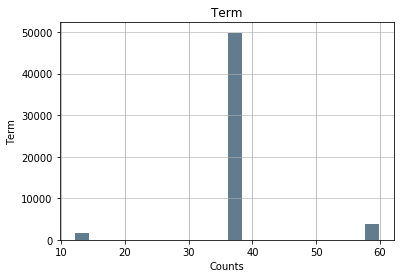

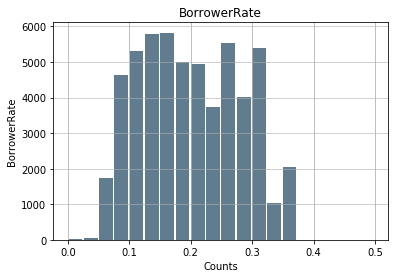

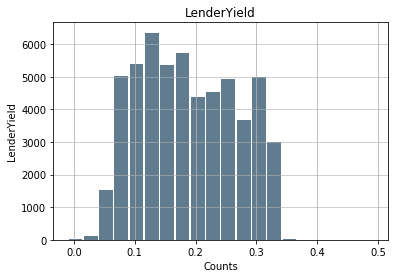

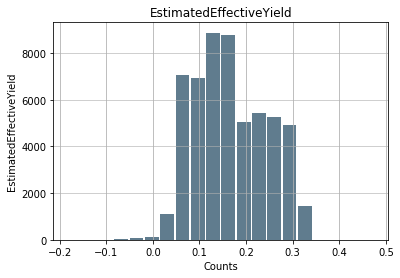

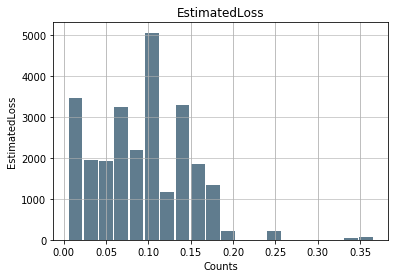

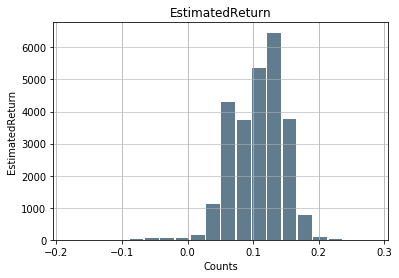

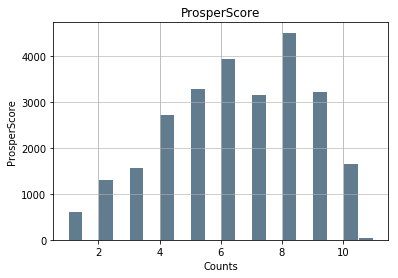

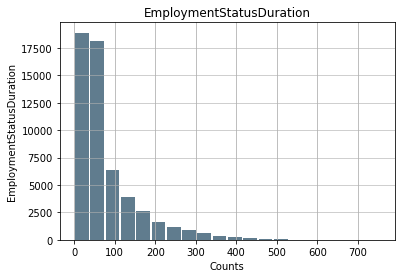

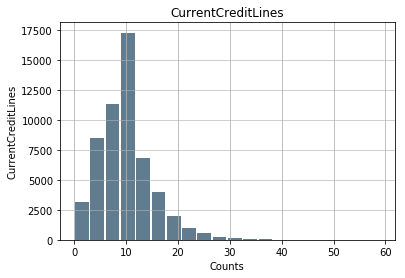

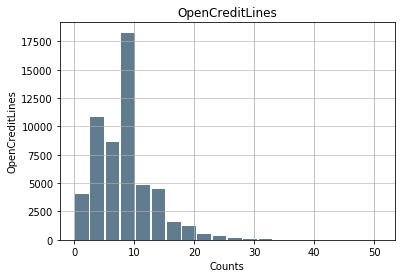

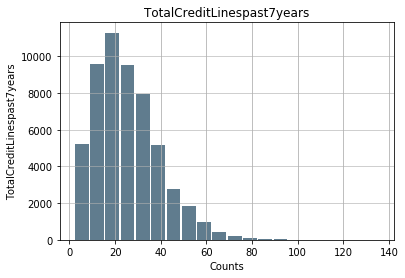

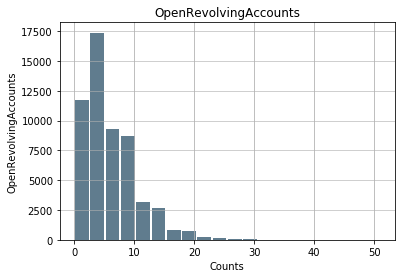

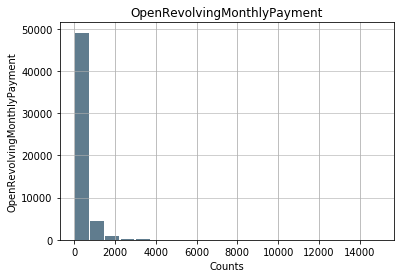

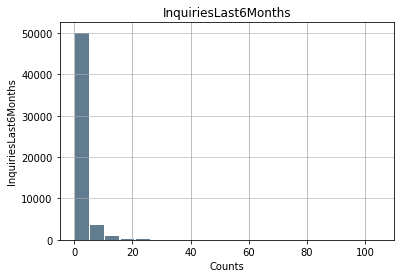

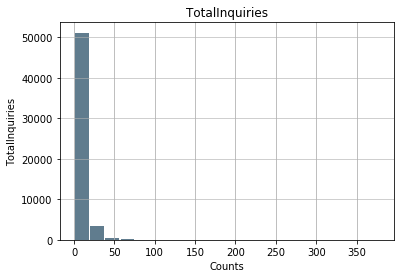

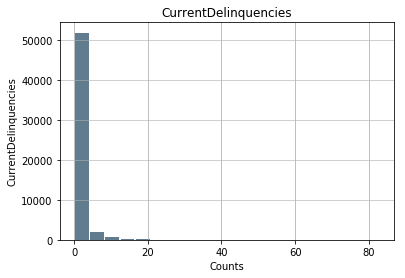

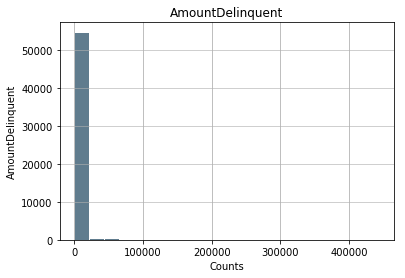

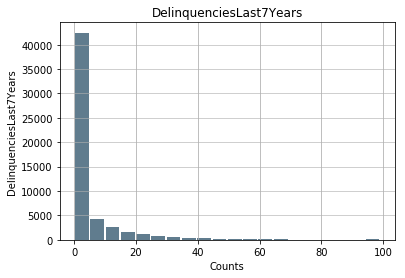

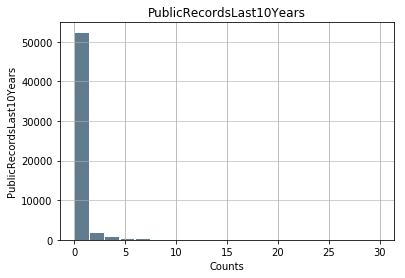

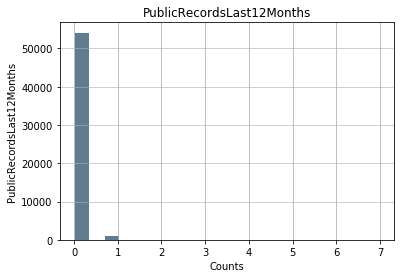

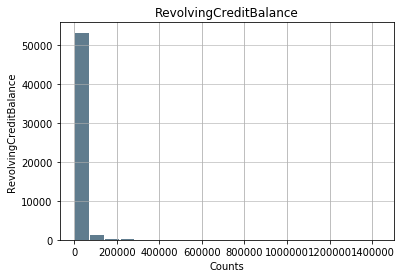

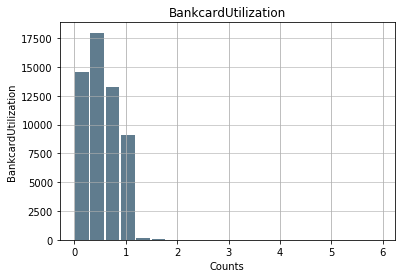

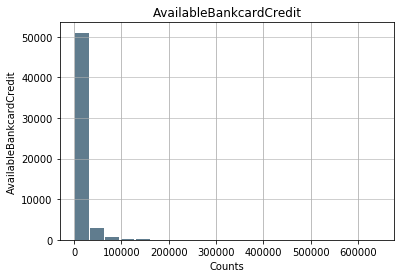

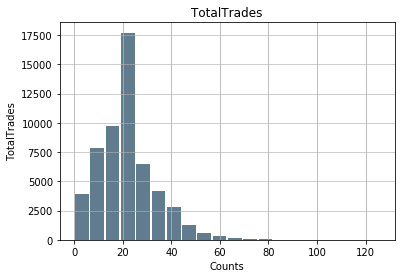

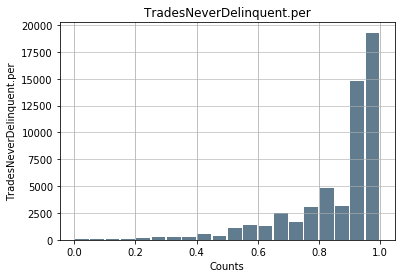

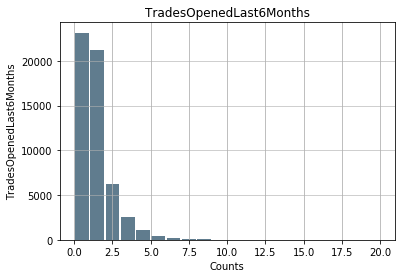

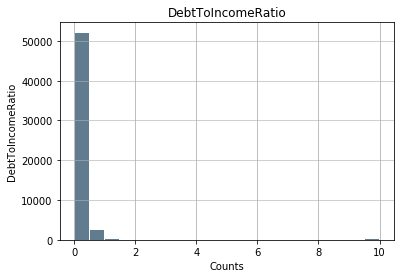

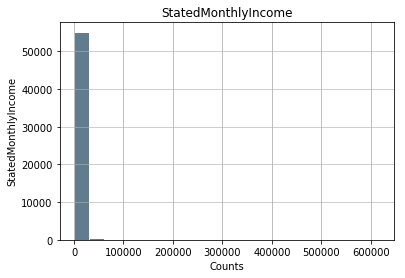

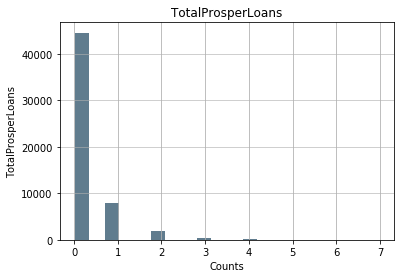

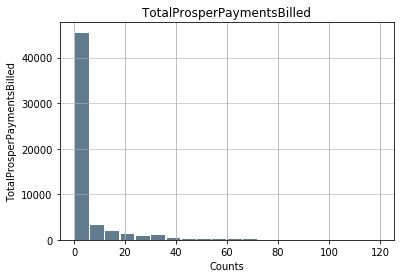

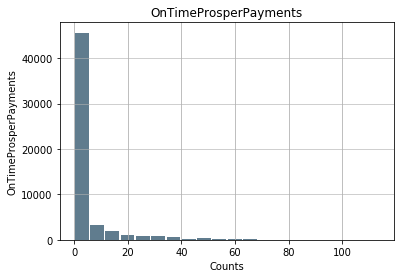

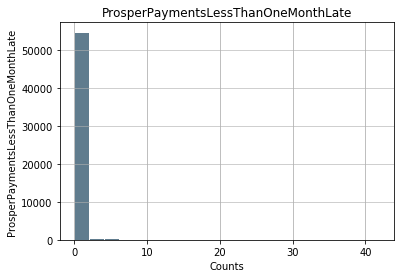

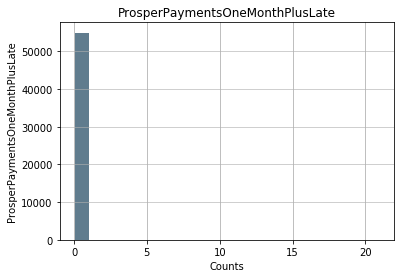

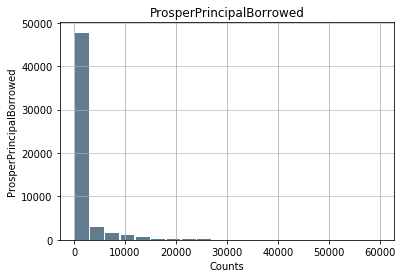

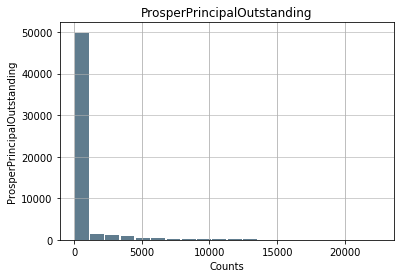

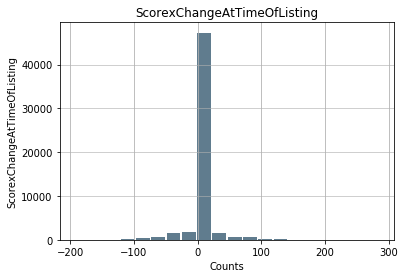

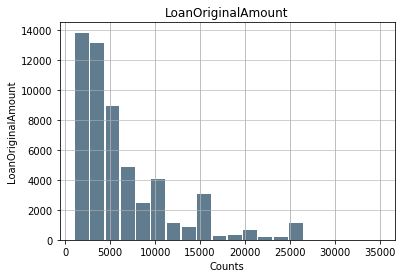

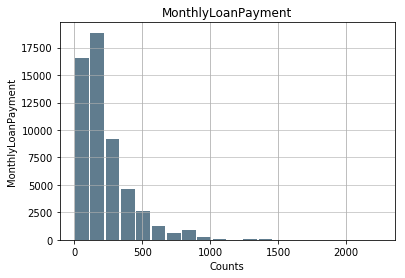

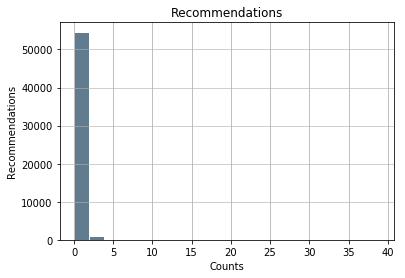

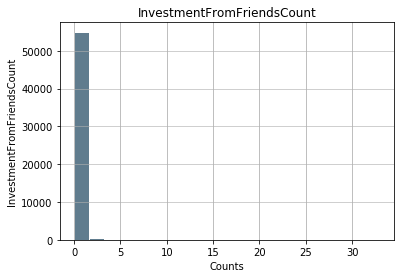

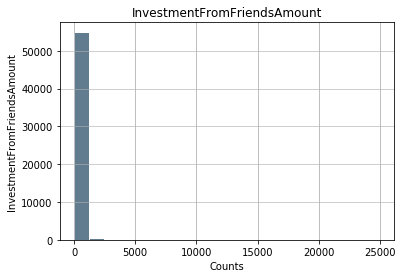

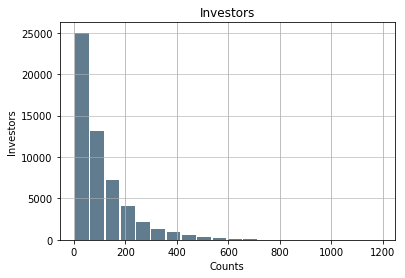

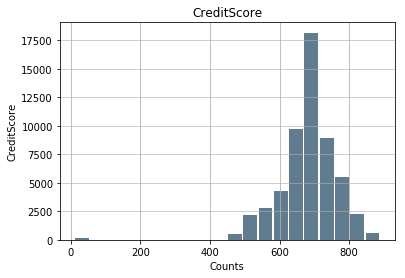

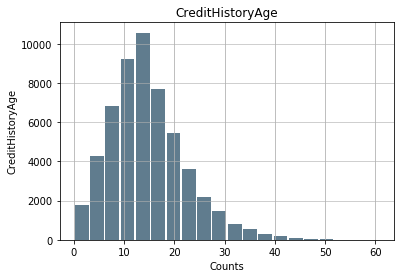

In [479]:
# Split the data into features and target label
completion = data["Completed.num"]
features_raw = data.drop("Completed.num", axis = 1)

# Visualize continuous features of original data
continuous_features = ["Term", "BorrowerRate", "LenderYield", "EstimatedEffectiveYield", 
                       "EstimatedLoss", "EstimatedReturn", "ProsperScore", "EmploymentStatusDuration", 
                       "CurrentCreditLines", "OpenCreditLines", "TotalCreditLinespast7years", 
                       "OpenRevolvingAccounts", "OpenRevolvingMonthlyPayment", "InquiriesLast6Months",
                       "TotalInquiries", "CurrentDelinquencies", "AmountDelinquent", "DelinquenciesLast7Years",
                       "PublicRecordsLast10Years", "PublicRecordsLast12Months", "RevolvingCreditBalance",
                       "BankcardUtilization", "AvailableBankcardCredit", "TotalTrades", 
                       "TradesNeverDelinquent.per", "TradesOpenedLast6Months", "DebtToIncomeRatio", 
                       "StatedMonthlyIncome", "TotalProsperLoans", "TotalProsperPaymentsBilled", 
                       "OnTimeProsperPayments", "ProsperPaymentsLessThanOneMonthLate", 
                       "ProsperPaymentsOneMonthPlusLate", "ProsperPrincipalBorrowed", 
                       "ProsperPrincipalOutstanding", "ScorexChangeAtTimeOfListing", "LoanOriginalAmount",
                       "MonthlyLoanPayment", "Recommendations", "InvestmentFromFriendsCount", 
                       "InvestmentFromFriendsAmount", "Investors", "CreditScore", "CreditHistoryAge"]

for feature in continuous_features:
    size, scale = 1000, 10
    data[feature].plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')
    plt.title(feature)
    plt.xlabel('Counts')
    plt.ylabel(feature)
    plt.grid(axis='y', alpha=0.75)
    plt.show()

Below, I perform a log-transformation on those features I noted to be skewed, adding a small number to `x`, since the logarithm of 0 is undefined.

/Users/eskrav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


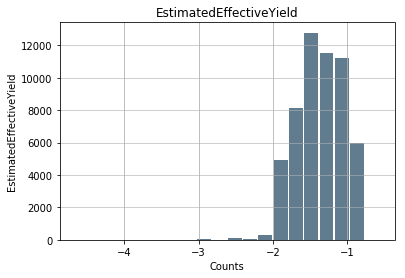

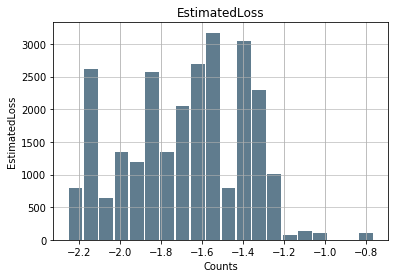

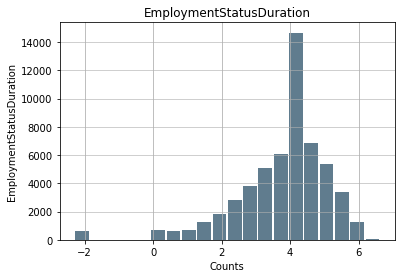

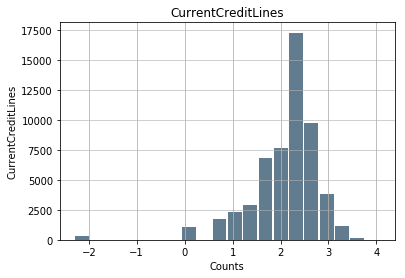

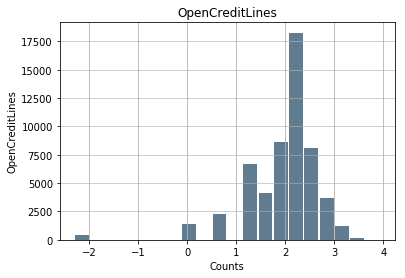

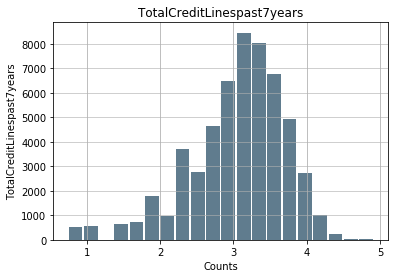

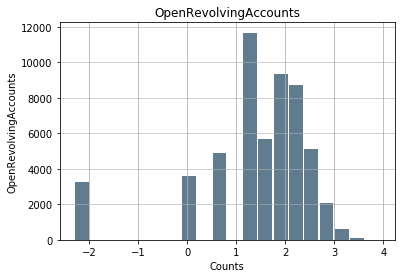

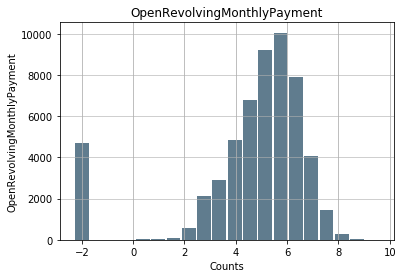

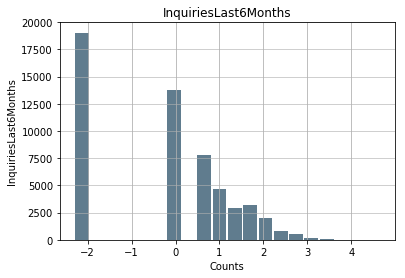

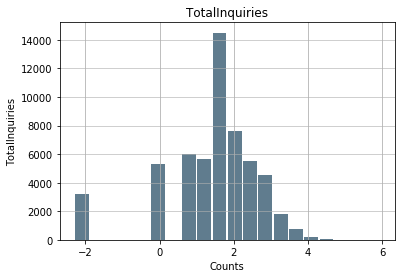

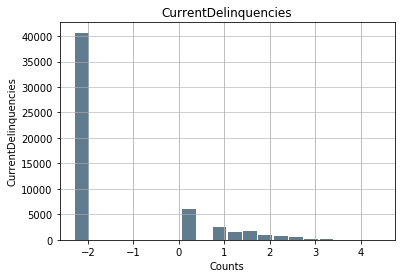

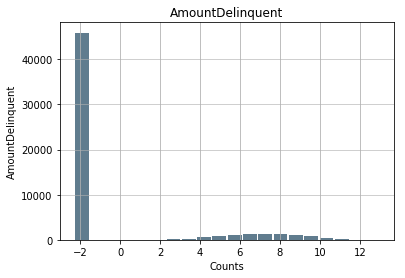

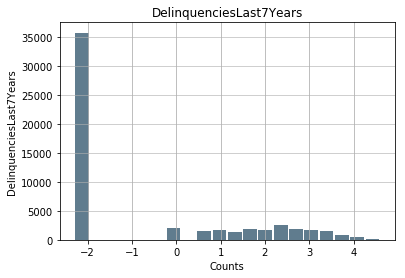

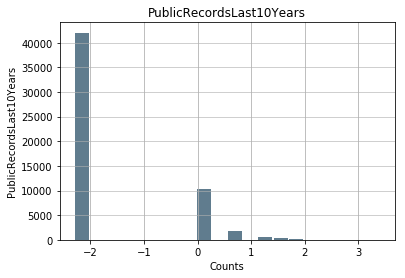

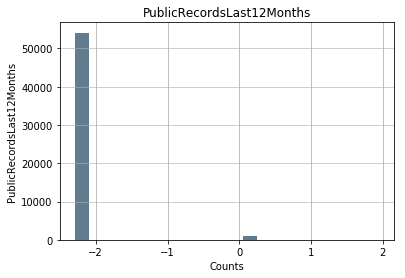

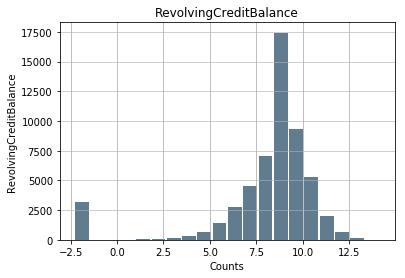

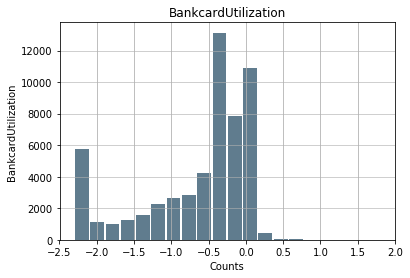

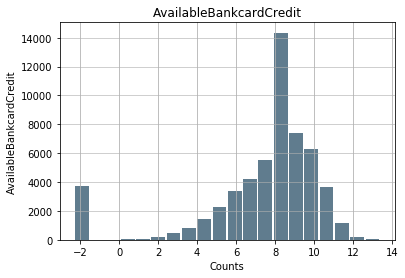

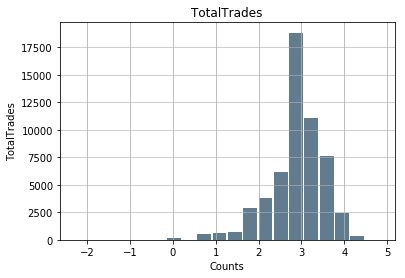

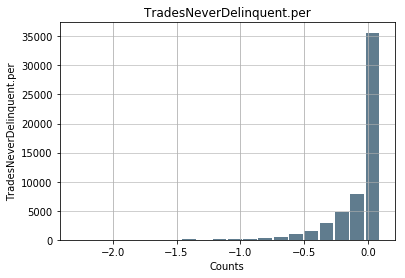

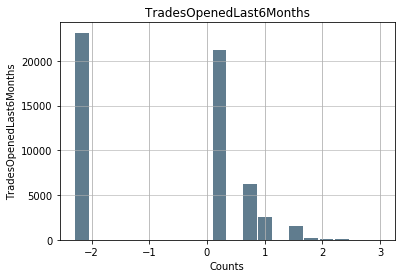

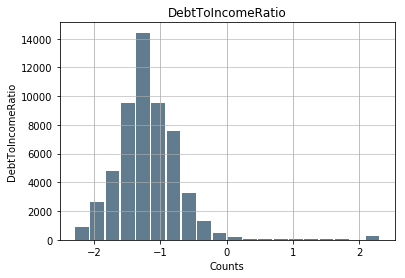

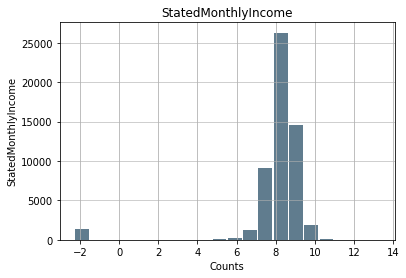

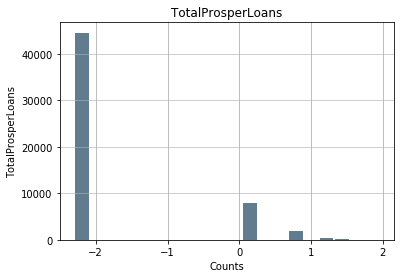

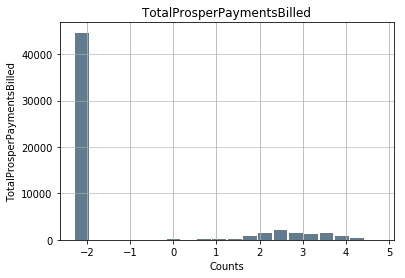

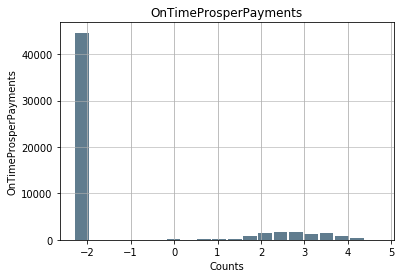

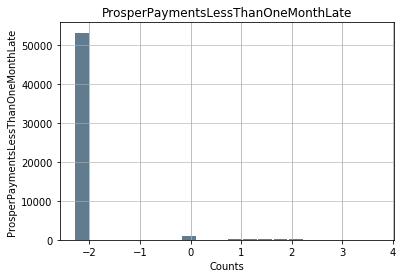

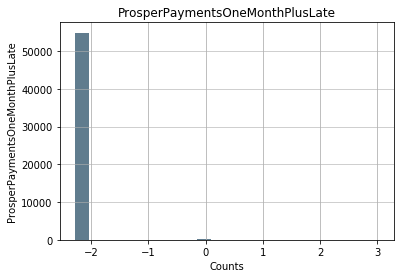

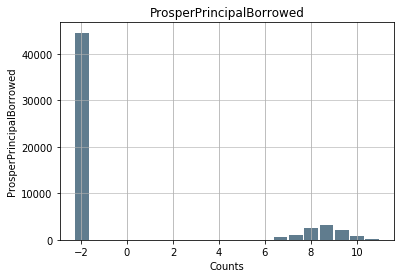

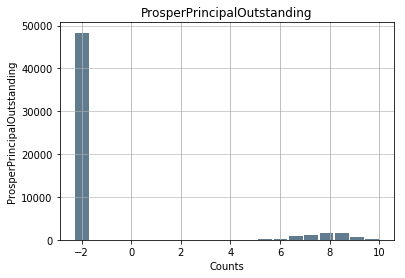

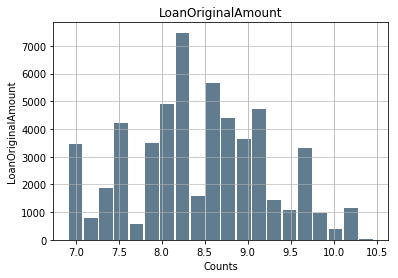

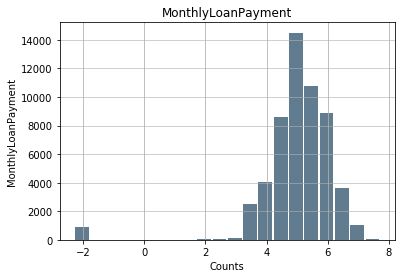

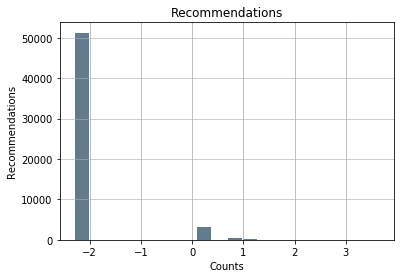

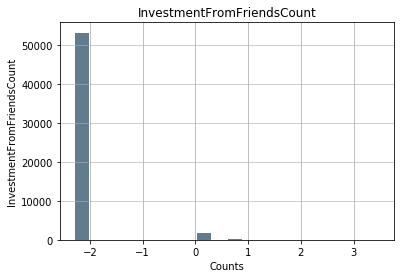

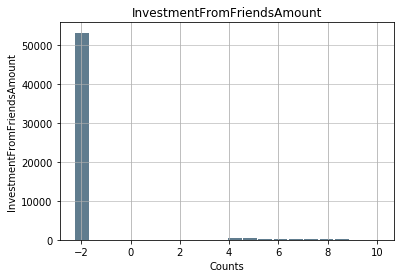

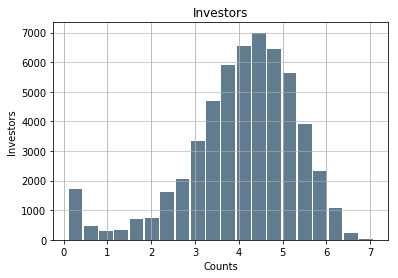

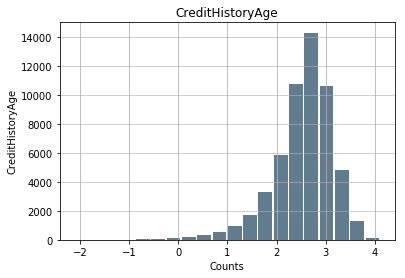

In [480]:
# Log-transform the skewed features
skewed = ['EstimatedEffectiveYield', 'EstimatedLoss', 'EmploymentStatusDuration', 'CurrentCreditLines',
          'OpenCreditLines', 'TotalCreditLinespast7years', 'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment',
          'InquiriesLast6Months', 'TotalInquiries', 'CurrentDelinquencies', 'AmountDelinquent', 
          'DelinquenciesLast7Years', 'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
          'RevolvingCreditBalance', 'BankcardUtilization', 'AvailableBankcardCredit', 'TotalTrades',
          'TradesNeverDelinquent.per', 'TradesOpenedLast6Months', 'DebtToIncomeRatio', 'StatedMonthlyIncome',
          'TotalProsperLoans', 'TotalProsperPaymentsBilled', 'OnTimeProsperPayments', 
          'ProsperPaymentsLessThanOneMonthLate', 'ProsperPaymentsOneMonthPlusLate', 'ProsperPrincipalBorrowed',
          'ProsperPrincipalOutstanding', 'LoanOriginalAmount', 'MonthlyLoanPayment', 'Recommendations',
          'InvestmentFromFriendsCount', 'InvestmentFromFriendsAmount', 'Investors', 'CreditHistoryAge']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 0.1))

# Visualize the new log distributions
for feature in skewed:
    size, scale = 1000, 10
    features_log_transformed[feature].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
    plt.title(feature)
    plt.xlabel('Counts')
    plt.ylabel(feature)
    plt.grid(axis='y', alpha=0.75)
    plt.show()

Many of the features are still not normally distributed, but their values are less extreme, and less likely to affect learning algorithms.  In the future, I may explore other transformations that can be applied to non-normally-distributed features.

### Coding Categorical Data

Since many learning algorithms only take numerical input, below I dummy-code categorical variables, with `0` indicating the absence of a feature/feature category, and `1` indicating its presence.

In [481]:
features_log_transformed.sample(10)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,CreditScore,CreditHistoryAge
12108,1183075200000000000,36,0.2500,0.2300,-1.119632,NaN,NaN,NaN,Unknown,Full-time,4.585987,False,1182816000000000000,2.714695,1.629241,3.830813,0.741937,4.812997,0.095310,2.778819,0.741937,6.066340,2.312535,-2.302585,-2.302585,6.808045,-0.415515,6.582164,3.640214,-0.274437,-2.302585,-0.776529,True,8.180349,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.0,8.411855,1184803200000000000,5.187498,-2.302585,-2.302585,-2.302585,4.683057,E,589.5,2.738717
29931,1307318400000000000,36,0.1029,0.0929,-1.647140,-2.071473,0.0666,9.0,Auto,Employed,5.412092,True,1307318400000000000,1.960095,1.808289,3.182212,1.131402,5.576328,-2.302585,0.095310,-2.302585,-2.302585,-2.302585,0.095310,-2.302585,9.222674,-0.755023,9.727711,3.095578,0.048790,-2.302585,-1.609438,True,8.753598,0.095310,1.808289,1.808289,-2.302585,-2.302585,6.907855,-2.302585,-10.0,8.006401,1307577600000000000,4.577902,-2.302585,-2.302585,-2.302585,4.235555,A,749.5,2.850865
20145,1181952000000000000,36,0.2800,0.2700,-1.031702,NaN,NaN,NaN,Unknown,Full-time,4.305416,False,1181520000000000000,1.808289,1.808289,2.493205,1.808289,5.447168,0.095310,1.808289,-2.302585,-2.302585,1.629241,-2.302585,-2.302585,8.955977,-0.127833,7.358895,2.493205,-0.162519,0.095310,-1.309333,True,8.251081,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.0,8.999632,1182816000000000000,5.814578,-2.302585,-2.302585,-2.302585,3.914021,D,609.5,2.667323
51628,1164931200000000000,36,0.0900,0.0850,-1.793361,NaN,NaN,NaN,Unknown,Not available,3.953165,False,1164499200000000000,2.208274,2.091864,2.493205,0.741937,3.666122,-2.302585,0.095310,-2.302585,-2.302585,-2.302585,0.095310,-2.302585,8.711624,-0.415515,8.085056,3.000720,0.019803,0.095310,-2.120264,True,8.207066,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.0,6.907855,1165449600000000000,3.462606,-2.302585,-2.302585,-2.302585,4.096010,B,709.5,2.512491
31658,1282262400000000000,36,0.2575,0.2475,-1.413049,-1.619488,0.1434,7.0,Reno,Full-time,3.586293,False,1281657600000000000,1.131402,1.131402,2.572612,1.131402,4.278054,0.741937,1.629241,-2.302585,-2.302585,2.839078,-2.302585,-2.302585,7.461123,0.058269,4.837075,2.572612,-0.342490,-2.302585,-1.609438,True,8.740353,0.095310,3.222868,3.222868,-2.302585,-2.302585,8.922672,7.878386,-1.0,8.987209,1283126400000000000,5.772562,-2.302585,-2.302585,-2.302585,5.425390,D,629.5,3.493806
3166,1195776000000000000,36,0.1700,0.1600,-1.400799,NaN,NaN,NaN,Unknown,Full-time,3.095578,False,1195776000000000000,0.741937,0.095310,2.208274,-2.302585,-2.302585,0.741937,1.131402,1.960095,8.313877,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,1.410987,-1.139434,-2.302585,-1.469676,True,7.491515,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.0,7.824086,1197936000000000000,4.491217,0.095310,0.095310,6.397096,1.410987,HR,549.5,1.937065
47940,1202342400000000000,36,0.3500,0.3400,-0.852377,NaN,NaN,NaN,Personal,

Below, I dummy-code all categorical features:

In [482]:
# dummy-code the log-transformed features
features_final = pd.get_dummies(features_log_transformed)

# Print the number of features after dummy-coding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

print(encoded)

88 total features after one-hot encoding.
['ListingCreationDate', 'Term', 'BorrowerRate', 'LenderYield', 'EstimatedEffectiveYield', 'EstimatedLoss', 'EstimatedReturn', 'ProsperScore', 'EmploymentStatusDuration', 'IsBorrowerHomeowner', 'DateCreditPulled', 'CurrentCreditLines', 'OpenCreditLines', 'TotalCreditLinespast7years', 'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months', 'TotalInquiries', 'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years', 'PublicRecordsLast10Years', 'PublicRecordsLast12Months', 'RevolvingCreditBalance', 'BankcardUtilization', 'AvailableBankcardCredit', 'TotalTrades', 'TradesNeverDelinquent.per', 'TradesOpenedLast6Months', 'DebtToIncomeRatio', 'IncomeVerifiable', 'StatedMonthlyIncome', 'TotalProsperLoans', 'TotalProsperPaymentsBilled', 'OnTimeProsperPayments', 'ProsperPaymentsLessThanOneMonthLate', 'ProsperPaymentsOneMonthPlusLate', 'ProsperPrincipalBorrowed', 'ProsperPrincipalOutstanding', 'ScorexChangeAtTimeOfListing

## Dimensionality Reduction

In this section, I use principal component analysis (PCA) to see if the features in my dataset can be reduced to fewer dimensions, which may improve algorithm performance, and reduce feature redundancy.

Below, I split the data into training and testing datasets.

In [483]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

X_train, X_test, y_train, y_test = train_test_split(features_final, completion, test_size=0.15, random_state=42)

### Normalizing Numerical Features

Prior to using PCA, I scale all numerical features, which ensures that algorithms treat features equally, rather than giving some undue weight .

In [484]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # default=(0, 1)

X_train_scaled = X_train
X_train_scaled[continuous_features] = scaler.fit_transform(X_train[continuous_features])

X_test_scaled = X_test
X_test_scaled[continuous_features] = scaler.fit_transform(X_test[continuous_features])

/Users/eskrav/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/eskrav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/eskrav/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/eskrav/anaconda3/lib/python3.6/site-package

In [485]:
# Show the results of the split
print("Training set has {} samples.".format(X_train_non_na.shape[0]))
print("Testing set has {} samples.".format(X_test_non_na.shape[0]))

Training set has 46821 samples.
Testing set has 8263 samples.


Below, I drop all columns with remaining missing values, and save the data to a separate testing/training set which can be used with algorithms which handle missing data natively.

In [486]:
X_test_scaled.sample(10)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,CreditScore,CreditHistoryAge,ListingCategory_Auto,ListingCategory_Baby,ListingCategory_Boat,ListingCategory_Business,ListingCategory_Cosmetic,ListingCategory_Debt,ListingCategory_Engagement,ListingCategory_Green,ListingCategory_Household,ListingCategory_LargePurchase,ListingCategory_Medical,ListingCategory_Motorcycle,ListingCategory_Other,ListingCategory_Personal,ListingCategory_RV,ListingCategory_Reno,ListingCategory_Student,ListingCategory_Taxes,ListingCategory_Unknown,ListingCategory_Vacation,ListingCategory_Wedding,EmploymentStatus_Employed,EmploymentStatus_Full-time,EmploymentStatus_Not available,EmploymentStatus_Not employed,EmploymentStatus_Other,EmploymentStatus_Part-time,EmploymentStatus_Retired,EmploymentStatus_Self-employed,EmploymentStatus_Unknown,Rating_A,Rating_AA,Rating_B,Rating_C,Rating_D,Rating_E,Rating_HR,Rating_NC,Rating_Unknown
53202,1205020800000000000,0.5,0.395833,0.390411,0.802780,NaN,NaN,NaN,0.556134,False,1205020800000000000,0.480988,0.498166,0.166034,0.494654,0.451062,0.000000,0.369701,0.000000,0.000000,0.538299,0.000000,0.0,0.485852,0.000000,0.000000,0.223211,0.747222,0.000000,0.039497,True,0.657437,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.445977,0.062759,1206316800000000000,0.602272,0.000000,0.0,0.0,0.552083,0.704545,0.524991,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
26068,1333411200000000000,0.5,0.882500,0.870411,0.967574,0.62147,0.647697,0.3,0.645029,False,1333411200000000000,0.781829,0.738098,0.698895,0.713981,0.719889,0.533751,0.533625,0.000000,0.000000,0.000000,0.000000,0.0,0.722442,0.481173,0.748871,0.739802,1.000000,0.500000,0.305666,True,0.674913,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.445977,0.389908,1333929600000000000,0.744418,0.000000,0.0,0.0,0.316035,0.840909,0.798616,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
31013,1174521600000000000,0.5,0.345833,0.327397,0.778252,NaN,NaN,NaN,0.661783,False,1174003200000000000,0.649456,0.672649,0.413195,0.638817,0.641262,0.437589,0.416994,0.000000,0.000000,0.000000,0.000000,0.0,0.660316,0.366612,0.754652,0.477669,1.000000,0.500000,0.380809,True,0.655009,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.445977,0.452671,1175558400000000000,0.740579,0.000000,0.0,0.0,0.717303,0.795455,0.579843,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
41056,1220400000000000000,0.5,0.715278,0.705479,0.923473,NaN,NaN,NaN,0.547867,False,1218585600000000000,0.621169,0.607640,0.668869,0.603356,0.519799,0.437589,0.533625,0.644154,0.757956,0.889064,0.634832,0.0,0.557483,0.440762,0.600830,0.533698,0.845804,0.000000,0.056837,True,0.665976,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.445977,0.000000,1221177600000000000,0.598479,0.000000,0.0,0.0,0.522144,0.704545,0.788799,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
22526,1165104000000000000,0.5,0.250000,0.260274,0.724394,NaN,NaN,NaN,0.703012,False,1165104000000000000,0.712647,0.719050,0.434

In [487]:
X_train_non_na = X_train_scaled.drop(['EstimatedEffectiveYield', 'EstimatedLoss',
                                      'EstimatedReturn', 'ProsperScore'], axis=1)
X_test_non_na = X_test_scaled.drop(['EstimatedEffectiveYield', 'EstimatedLoss',
                                    'EstimatedReturn', 'ProsperScore'], axis=1)

X_train_full = X_train_scaled
X_test_full = X_test_scaled

### Applying Dimensionality Reduction

Below, I reduce the features to 10 components, and then 3 components.  I further reduce the dataset to the top 30% of most important features (those that account for the most variance), and to the top 10%.  All are saved to separate testing/training sets.

In [488]:
from sklearn.decomposition import PCA

# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=10, random_state=42)
pca.fit(X_train_non_na)

X_train_pca10 = pca.transform(X_train_non_na)
X_test_pca10 = pca.transform(X_test_non_na)

pca.explained_variance_ratio_

array([9.99553652e-01, 4.25776825e-04, 2.05712758e-05, 2.80739589e-35,
       2.24527097e-35, 1.80334338e-35, 1.50403109e-35, 1.47244438e-35,
       1.30543000e-35, 1.12248265e-35])

In [489]:
pca = PCA(n_components=3, random_state=42)
pca.fit(X_train_non_na)

X_train_pca3 = pca.transform(X_train_non_na)
X_test_pca3 = pca.transform(X_test_non_na)

pca.explained_variance_ratio_

array([9.99553652e-01, 4.25776825e-04, 2.05712758e-05])

In [490]:
from sklearn.feature_selection import SelectPercentile

X_train_reduce30 = SelectPercentile(percentile=30).fit_transform(X_train_non_na, y_train)
X_test_reduce30 = SelectPercentile(percentile=30).fit_transform(X_test_non_na, y_test)

X_train_reduce10 = SelectPercentile(percentile=10).fit_transform(X_train_non_na, y_train)
X_test_reduce10 = SelectPercentile(percentile=10).fit_transform(X_test_non_na, y_test)

Above, it looks like the most important feature accounts for quite a bit of the variance, and the rest account for comparatively tiny portions.  This may make the use of a highly reduced dataset feasible.

----
## Evaluating Model Performance


### The Naive Predictor

Below, we look at how a simple model, which always predicted that a loan was completed, performed.  Although the accuracy and F-score in this case is rather high, and the general goal is to maximize recall (identify all defaults), it is clear that this model performs rather poorly.  An improved model must have higher precision, even if at the expense of Recall.

In [491]:
# true positives
TP = np.sum(completion)
# false positives
FP = completion.count() - TP

# true negatives
TN = 0
# false negatives
FN = 0

# accuracy, precision and recall
accuracy = TP/(TP+FP)
recall = TP/(TP+FN)
precision = TP/(TP+FP)

# F-score for beta = 1
fscore = (1+1**2) * (precision * recall)/(1**2 * precision + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}, Precision: {:.4f}, Recall: {:.4f}]".format(accuracy, fscore, precision, recall))

Naive Predictor: [Accuracy score: 0.6912, F-score: 0.8174, Precision: 0.6912, Recall: 1.0000]


## Model Application


**Answer: **

I picked three Ensemble methods commonly used for the task of classification - one averaging method, and two boosting methods.  I also picked Logistic Regression, as having an output of probabilities allows for more interpretability, flexibility after the fact in setting thresholds for decisions.  I broadly retain some of my previous descriptions of these models, where I have previously used them.

For strengths and weaknesses of the relevant models, I primarily consulted the following sources, keeping in mind that heuristics do not necessarily apply to each data set:

https://medium.com/@randylaosat/machine-learning-whats-inside-the-box-861f5c7e72a3

https://medium.com/@vijaya.beeravalli/comparison-of-machine-learning-classification-models-for-credit-card-default-data-c3cf805c9a5a

https://www.dummies.com/programming/big-data/data-science/machine-learning-dummies-cheat-sheet/

https://hackernoon.com/boosting-algorithms-adaboost-gradient-boosting-and-xgboost-f74991cad38c

https://medium.com/@grohith327/gradient-boosting-and-xgboost-90862daa6c77

#### Ensemble Methods: Random Forest

The strengths of this model are the following: it natively handles categorical variables; it is less prone to overfitting than a single decision tree -- therefore, it is more likely to select relevant features; and it frequently outperforms other methods on accuracy.  **These features make this model a good candidate for this problem, which has numerous categorical and continuous features.  Given that after one-hot conversion, there were 88 total features, a model which will automatically select the most important features is of particular importance.**  Additionally, it can handle imbalanced data, such as this dataset, and is a flexible algorithm that does not require lots of parameter tuning.

The weaknesses of this model are that it won't perform well with a bad set of features; it's not very transparent, and it's hard to interpret what's going on in the algorithm; further, too many trees can slow down the algorithm.

#### Ensemble Methods: AdaBoost

AdaBoost is particularly well-suited for boosting the performance of decision trees on binary classification tasks.  It typically does not overfit despite excellent accuracy (although it is to date unclear exactly how), and frequently outperforms other methods.  **These features make it a good model to attempt for this problem, given that the algorithm can be used to boost the performance of classifiers that work well natively with categorical data, such as decision trees, and like RF will automatically select those features that are most important.**  It additionally can handle missing variables, and does not require variable transformation, and has relatively few parameters that need tweaking.

The weaknesses of this model are that it does not deal well with noisy data, and the efficiency of the algorithm is affected by outliers, since the algorithm attempts to fit each point.

#### Logistic Regression

The strengths of this model are that it's fairly easy to interpret in terms of probabilities; relatively unlikely to overfit; fast; well-suited for binary classification tasks; and explanatory variables can be continuous or categorical.  **These features, and in particular the fact that results are probabilities, make this model a good candidate for this problem, since probabilities allow for post-hoc adjustment of the threshold for whether a lender should fund a particular loan, perhaps depending on their personal finances or risk aversion.**

The downsides of this model are that it's not particularly good at capturing complex or non-linear relationships between features, or dealing with multiple/non-linear decision boundaries; generally, it's not very flexible.

#### Ensemble Methods: XGBoost

XGBoost was recommended by a reviewer, is highly robust to irregularities in data, and like AdaBoost, is a boosting algorithm which tries to create a strong classifier from a series of weaker classifiers.  **Given that the dataset I have is quite noisy, with quite a bit of missing or imputed data, and is particularly suited to decision trees, this algorithm would be appropriate to try.**

### Training and Predicting Pipeline

Below I use a training function from another Udacity project to evaluate the peformance of the various classifiers, with repect to time and various metrics, on testing and training data.

In [492]:
from sklearn.metrics import fbeta_score, accuracy_score, f1_score, precision_score, recall_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    results['train_time'] = end - start
        
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    results['pred_time'] = end - start
            
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train[:300])
        
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    results['f_train'] = f1_score(y_train[:300], predictions_train[:300])
        
    results['f_test'] = f1_score(y_test, predictions_test)
    
    results['p_train'] = precision_score(y_train[:300], predictions_train[:300])
        
    results['p_test'] = precision_score(y_test, predictions_test)
    
    results['r_train'] = recall_score(y_train[:300], predictions_train[:300])
        
    results['r_test'] = recall_score(y_test, predictions_test)
       
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    return results

### Model Evaluation


#### Full dataset without missing data

In [493]:
from time import time

clf_A = RandomForestClassifier(random_state = 42)
clf_B = AdaBoostClassifier(random_state = 42)
clf_C = LogisticRegression(random_state = 42)
clf_D = XGBClassifier(random_state = 42)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

results_non_na = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results_non_na[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_non_na[clf_name][i] = \
        train_predict(clf, samples, X_train_non_na, y_train, X_test_non_na, y_test)

/Users/eskrav/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier trained on 468 samples.
RandomForestClassifier trained on 4682 samples.
RandomForestClassifier trained on 46821 samples.
AdaBoostClassifier trained on 468 samples.
AdaBoostClassifier trained on 4682 samples.
AdaBoostClassifier trained on 46821 samples.
LogisticRegression trained on 468 samples.


/Users/eskrav/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/eskrav/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression trained on 4682 samples.


/Users/eskrav/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression trained on 46821 samples.
XGBClassifier trained on 468 samples.
XGBClassifier trained on 4682 samples.
XGBClassifier trained on 46821 samples.


In [494]:
pd.DataFrame(results_non_na['RandomForestClassifier'])

,0,1,2
acc_test,0.616967,0.650732,0.657509
acc_train,1.000000,0.990000,0.983333
f_test,0.699744,0.723722,0.731142
f_train,1.000000,0.992366,0.987342
p_test,0.754346,0.788486,0.789495
p_train,1.000000,0.994898,0.984848
pred_time,0.099689,0.112470,0.098830
r_test,0.652512,0.668790,0.680821
r_train,1.000000,0.989848,0.989848
train_time,0.046598,0.198521,2.208237


In [495]:
pd.DataFrame(results_non_na['AdaBoostClassifier'])

,0,1,2
acc_test,0.657872,0.690185,0.721651
acc_train,0.863333,0.763333,0.733333
f_test,0.749978,0.763881,0.805118
f_train,0.900726,0.836028,0.818182
p_test,0.749779,0.797881,0.772520
p_train,0.861111,0.766949,0.740741
pred_time,0.126809,0.123077,0.138360
r_test,0.750177,0.732661,0.840587
r_train,0.944162,0.918782,0.913706
train_time,0.114988,0.675160,5.631585


In [496]:
pd.DataFrame(results_non_na['LogisticRegression'])

,0,1,2
acc_test,0.684013,0.684013,0.684013
acc_train,0.656667,0.656667,0.656667
f_test,0.812361,0.812361,0.812361
f_train,0.792757,0.792757,0.792757
p_test,0.684013,0.684013,0.684013
p_train,0.656667,0.656667,0.656667
pred_time,0.052893,0.056935,0.114004
r_test,1.000000,1.000000,1.000000
r_train,1.000000,1.000000,1.000000
train_time,0.009092,0.075564,0.991711


In [497]:
pd.DataFrame(results_non_na['XGBClassifier'])

,0,1,2
acc_test,0.689338,0.720804,0.731453
acc_train,0.960000,0.783333,0.753333
f_test,0.786599,0.804508,0.817951
f_train,0.970443,0.853273,0.836283
p_test,0.741885,0.771995,0.762582
p_train,0.942584,0.768293,0.741176
pred_time,0.115769,0.104637,0.130615
r_test,0.837049,0.839880,0.881989
r_train,1.000000,0.959391,0.959391
train_time,0.341369,2.201664,21.826490


#### PCA: 10 most important features

In [498]:
clf_A = RandomForestClassifier(random_state = 42)
clf_B = AdaBoostClassifier(random_state = 42)
clf_C = LogisticRegression(random_state = 42)
clf_D = XGBClassifier(random_state = 42)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

results_pca10 = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results_pca10[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_pca10[clf_name][i] = \
        train_predict(clf, samples, X_train_pca10, y_train, X_test_pca10, y_test)

/Users/eskrav/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier trained on 468 samples.
RandomForestClassifier trained on 4682 samples.
RandomForestClassifier trained on 46821 samples.
AdaBoostClassifier trained on 468 samples.
AdaBoostClassifier trained on 4682 samples.
AdaBoostClassifier trained on 46821 samples.
LogisticRegression trained on 468 samples.
LogisticRegression trained on 4682 samples.
LogisticRegression trained on 46821 samples.


/Users/eskrav/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/eskrav/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/eskrav/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


XGBClassifier trained on 468 samples.
XGBClassifier trained on 4682 samples.
XGBClassifier trained on 46821 samples.


In [499]:
pd.DataFrame(results_pca10['RandomForestClassifier'])

,0,1,2
acc_test,0.618783,0.655815,0.661019
acc_train,0.980000,0.986667,0.990000
f_test,0.722565,0.753168,0.756668
f_train,0.984772,0.989796,0.992443
p_test,0.719397,0.739182,0.743301
p_train,0.984772,0.994872,0.985000
pred_time,0.020613,0.022374,0.036212
r_test,0.725761,0.767693,0.770524
r_train,0.984772,0.984772,1.000000
train_time,0.028403,0.271368,2.342732


In [500]:
pd.DataFrame(results_pca10['AdaBoostClassifier'])

,0,1,2
acc_test,0.652184,0.694058,0.697446
acc_train,0.833333,0.710000,0.693333
f_test,0.757223,0.798982,0.803583
f_train,0.881517,0.811280,0.800866
p_test,0.724539,0.725592,0.722725
p_train,0.826667,0.708333,0.698113
pred_time,0.064325,0.078012,0.057640
r_test,0.792994,0.888889,0.904812
r_train,0.944162,0.949239,0.939086
train_time,0.088541,0.439066,4.369478


In [501]:
pd.DataFrame(results_pca10['LogisticRegression'])

,0,1,2
acc_test,0.554036,0.528743,0.530437
acc_train,0.576667,0.546667,0.543333
f_test,0.614419,0.578023,0.579905
f_train,0.618619,0.577640,0.573209
p_test,0.751857,0.745805,0.747210
p_train,0.757353,0.744000,0.741935
pred_time,0.000852,0.000589,0.000582
r_test,0.519462,0.471868,0.473815
r_train,0.522843,0.472081,0.467005
train_time,0.001558,0.010615,0.142079


In [502]:
pd.DataFrame(results_pca10['XGBClassifier'])

,0,1,2
acc_test,0.663197,0.700351,0.701440
acc_train,0.920000,0.733333,0.690000
f_test,0.769447,0.806229,0.809218
f_train,0.942029,0.826087,0.800857
p_test,0.723477,0.722846,0.718780
p_train,0.898618,0.722433,0.692593
pred_time,0.035545,0.025031,0.027109
r_test,0.821656,0.911359,0.925690
r_train,0.989848,0.964467,0.949239
train_time,0.085050,0.779270,5.975151


#### PCA: 3 most important features

In [503]:
clf_A = RandomForestClassifier(random_state = 42)
clf_B = AdaBoostClassifier(random_state = 42)
clf_C = LogisticRegression(random_state = 42)
clf_D = XGBClassifier(random_state = 42)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

results_pca3 = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results_pca3[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_pca3[clf_name][i] = \
        train_predict(clf, samples, X_train_pca3, y_train, X_test_pca3, y_test)

RandomForestClassifier trained on 468 samples.


/Users/eskrav/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier trained on 4682 samples.
RandomForestClassifier trained on 46821 samples.
AdaBoostClassifier trained on 468 samples.
AdaBoostClassifier trained on 4682 samples.
AdaBoostClassifier trained on 46821 samples.
LogisticRegression trained on 468 samples.
LogisticRegression trained on 4682 samples.
LogisticRegression trained on 46821 samples.
XGBClassifier trained on 468 samples.


/Users/eskrav/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/eskrav/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/eskrav/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


XGBClassifier trained on 4682 samples.
XGBClassifier trained on 46821 samples.


In [504]:
pd.DataFrame(results_pca3['RandomForestClassifier'])

,0,1,2
acc_test,0.608254,0.603050,0.609222
acc_train,0.993333,0.966667,0.883333
f_test,0.719327,0.714286,0.723616
f_train,0.994898,0.974874,0.914005
p_test,0.705322,0.703500,0.700879
p_train,1.000000,0.965174,0.885714
pred_time,0.013217,0.037694,0.040451
r_test,0.733900,0.725407,0.747877
r_train,0.989848,0.984772,0.944162
train_time,0.016099,0.095057,1.158985


In [505]:
pd.DataFrame(results_pca3['AdaBoostClassifier'])

,0,1,2
acc_test,0.649159,0.682924,0.683287
acc_train,0.750000,0.676667,0.650000
f_test,0.772467,0.809455,0.809631
f_train,0.835165,0.802444,0.787018
p_test,0.694174,0.687207,0.687461
p_train,0.736434,0.670068,0.655405
pred_time,0.052677,0.085433,0.054582
r_test,0.870665,0.984607,0.984607
r_train,0.964467,1.000000,0.984772
train_time,0.066247,0.221864,1.551570


In [506]:
pd.DataFrame(results_pca3['LogisticRegression'])

,0,1,2
acc_test,0.554036,0.528743,0.530437
acc_train,0.576667,0.546667,0.543333
f_test,0.614419,0.578023,0.579905
f_train,0.618619,0.577640,0.573209
p_test,0.751857,0.745805,0.747210
p_train,0.757353,0.744000,0.741935
pred_time,0.000338,0.000302,0.000346
r_test,0.519462,0.471868,0.473815
r_train,0.522843,0.472081,0.467005
train_time,0.001967,0.009089,0.080270


In [507]:
pd.DataFrame(results_pca3['XGBClassifier'])

,0,1,2
acc_test,0.650611,0.681714,0.683892
acc_train,0.823333,0.673333,0.653333
f_test,0.771073,0.807636,0.810505
f_train,0.878719,0.798354,0.789474
p_test,0.698664,0.688404,0.686916
p_train,0.800000,0.671280,0.656566
pred_time,0.021979,0.018494,0.019669
r_test,0.860226,0.976822,0.988323
r_train,0.974619,0.984772,0.989848
train_time,0.028661,0.305892,2.545372


#### PCA: top 30% of features

In [508]:
clf_A = RandomForestClassifier(random_state = 42)
clf_B = AdaBoostClassifier(random_state = 42)
clf_C = LogisticRegression(random_state = 42)
clf_D = XGBClassifier(random_state = 42)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

results_reduce30 = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results_reduce30[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_reduce30[clf_name][i] = \
        train_predict(clf, samples, X_train_reduce30, y_train, X_test_reduce30, y_test)

RandomForestClassifier trained on 468 samples.


/Users/eskrav/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier trained on 4682 samples.
RandomForestClassifier trained on 46821 samples.
AdaBoostClassifier trained on 468 samples.
AdaBoostClassifier trained on 4682 samples.
AdaBoostClassifier trained on 46821 samples.
LogisticRegression trained on 468 samples.
LogisticRegression trained on 4682 samples.


/Users/eskrav/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/eskrav/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/eskrav/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression trained on 46821 samples.
XGBClassifier trained on 468 samples.
XGBClassifier trained on 4682 samples.
XGBClassifier trained on 46821 samples.


In [509]:
pd.DataFrame(results_reduce30['RandomForestClassifier'])

,0,1,2
acc_test,0.399250,0.521602,0.494494
acc_train,0.996667,0.996667,0.983333
f_test,0.294084,0.561119,0.501373
f_train,0.997455,0.997455,0.987342
p_test,0.749275,0.753204,0.770642
p_train,1.000000,1.000000,0.984848
pred_time,0.018994,0.034155,0.030138
r_test,0.182944,0.447098,0.371550
r_train,0.994924,0.994924,0.989848
train_time,0.019680,0.144890,1.557661


In [510]:
pd.DataFrame(results_reduce30['AdaBoostClassifier'])

,0,1,2
acc_test,0.432289,0.691758,0.620114
acc_train,0.830000,0.736667,0.703333
f_test,0.411934,0.808913,0.687631
f_train,0.877108,0.820046,0.803532
p_test,0.706667,0.702227,0.785763
p_train,0.834862,0.743802,0.710938
pred_time,0.061146,0.063688,0.063442
r_test,0.290694,0.953822,0.611288
r_train,0.923858,0.913706,0.923858
train_time,0.084636,0.356691,2.739955


In [511]:
pd.DataFrame(results_reduce30['LogisticRegression'])

,0,1,2
acc_test,0.684013,0.684013,0.684013
acc_train,0.656667,0.656667,0.656667
f_test,0.812361,0.812361,0.812361
f_train,0.792757,0.792757,0.792757
p_test,0.684013,0.684013,0.684013
p_train,0.656667,0.656667,0.656667
pred_time,0.009610,0.006214,0.007567
r_test,1.000000,1.000000,1.000000
r_train,1.000000,1.000000,1.000000
train_time,0.003044,0.021365,0.320820


In [512]:
pd.DataFrame(results_reduce30['XGBClassifier'])

,0,1,2
acc_test,0.466417,0.665255,0.621082
acc_train,0.926667,0.763333,0.726667
f_test,0.466546,0.761305,0.679431
f_train,0.946078,0.840449,0.820175
p_test,0.737849,0.743093,0.806318
p_train,0.914692,0.754032,0.722008
pred_time,0.069317,0.045898,0.047042
r_test,0.341118,0.780432,0.587049
r_train,0.979695,0.949239,0.949239
train_time,0.160803,0.897107,7.500588


#### PCA: top 10% of features

In [513]:
clf_A = RandomForestClassifier(random_state = 42)
clf_B = AdaBoostClassifier(random_state = 42)
clf_C = LogisticRegression(random_state = 42)
clf_D = XGBClassifier(random_state = 42)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

results_reduce10 = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results_reduce10[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_reduce10[clf_name][i] = \
        train_predict(clf, samples, X_train_reduce10, y_train, X_test_reduce10, y_test)

RandomForestClassifier trained on 468 samples.


/Users/eskrav/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier trained on 4682 samples.
RandomForestClassifier trained on 46821 samples.
AdaBoostClassifier trained on 468 samples.
AdaBoostClassifier trained on 4682 samples.
AdaBoostClassifier trained on 46821 samples.
LogisticRegression trained on 468 samples.
LogisticRegression trained on 4682 samples.


/Users/eskrav/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/eskrav/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/eskrav/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression trained on 46821 samples.
XGBClassifier trained on 468 samples.
XGBClassifier trained on 4682 samples.
XGBClassifier trained on 46821 samples.


In [514]:
pd.DataFrame(results_reduce10['RandomForestClassifier']) # 62.2/71.3/68.6

,0,1,2
acc_test,0.592158,0.615757,0.622292
acc_train,0.980000,0.996667,0.980000
f_test,0.667522,0.692434,0.713064
f_train,0.984536,0.997455,0.984848
p_test,0.754460,0.765147,0.742201
p_train,1.000000,1.000000,0.979899
pred_time,0.014011,0.028935,0.040050
r_test,0.598549,0.632343,0.686129
r_train,0.969543,0.994924,0.989848
train_time,0.015079,0.080302,1.016110


In [515]:
pd.DataFrame(results_reduce10['AdaBoostClassifier']) # 65.6/73.6/70.2

,0,1,2
acc_test,0.636815,0.679172,0.655815
acc_train,0.766667,0.703333,0.703333
f_test,0.716913,0.765170,0.736423
f_train,0.832536,0.804396,0.806100
p_test,0.767832,0.766188,0.773258
p_train,0.787330,0.709302,0.706107
pred_time,0.063624,0.060869,0.056306
r_test,0.672328,0.764154,0.702937
r_train,0.883249,0.928934,0.939086
train_time,0.067690,0.208090,1.337007


In [516]:
pd.DataFrame(results_reduce10['LogisticRegression']) # 68.6/77.5/79

,0,1,2
acc_test,0.692122,0.682924,0.686918
acc_train,0.703333,0.706667,0.703333
f_test,0.783784,0.771498,0.775492
f_train,0.806941,0.807860,0.806941
p_test,0.754171,0.760750,0.761029
p_train,0.704545,0.708812,0.704545
pred_time,0.002534,0.001816,0.004022
r_test,0.815817,0.782555,0.790517
r_train,0.944162,0.939086,0.944162
train_time,0.002009,0.009832,0.170104


In [517]:
pd.DataFrame(results_reduce10['XGBClassifier']) # 69.8/79.4/85.2

,0,1,2
acc_test,0.653395,0.702287,0.698294
acc_train,0.853333,0.746667,0.726667
f_test,0.746279,0.804296,0.794561
f_train,0.892683,0.831858,0.822511
p_test,0.747339,0.730703,0.743637
p_train,0.859155,0.737255,0.716981
pred_time,0.046555,0.043523,0.028126
r_test,0.745223,0.894374,0.852972
r_train,0.928934,0.954315,0.964467
train_time,0.067221,0.508011,3.378483


----
## Optimizing Results

**AdaBoost and XGBoost perform roughly similar on the testing data, and are generally superior to Random Forest or Logistic Regression.  Although AdaBoost trained faster, the two algorithms generally showed similar performance on the F1 metric, Recall, and Precision.  Both are similarly well-suited for the a large number of continuous and categorical variables, as seen in this dataset, given that ensemble methods will pick out the most important features, and decision tree-based classifiers are paticularly well-suited to categorical data.  Overall, due to it being able to achieve high precision scores alongside reasonably high recall and F1 scores on the full dataset, I will use the AdaBoost method.  Below I briefly discuss how this method works.**

**AdaBoost takes a family of weak classifiers, which may perform only slightly better than chance at correctly classifying any given point, combines them, and lets them 'vote' on the correct category of any given point.  When a large number of such weak classifiers vote on any given point, the chance that this point will be correctly classified increases significantly.  By default, AdaBoost uses decision tree classifiers to classify points, although it can use different base classifiers.  The process of classifying points continues either until each point is correctly classified in a labeled data set, or until the maximum number of iterations specified is reached.**

**The image below illustrates this: a weak classifier in Box 1 classifies several of the positive points correctly, but misclassifies the rest of the positive points.  The weights of the misclassified samples are then increased, and the next weak classifier (Box 2) is more likely to classify these points correctly.  The weights of misclassified samples is increased again, and the process repeats.  In the end, the weak classifiers are combined, and 'vote' on the category a given point belongs to:**

![Image](image.png)

**The drawback of this method, as mentioned, is that it does not deal well with noisy data, given that it attempts to categorize all points correctly.  It is not, however, prone to overfitting.**

Resources:

https://hackernoon.com/boosting-algorithms-adaboost-gradient-boosting-and-xgboost-f74991cad38c (image copied from this resource)

### Model Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

clf = AdaBoostClassifier(random_state=42)

parameters = dict(n_estimators=[10, 50, 100, 250, 500, 1000], 
                  learning_rate=[0.01, 0.1, 0.5, 1], 
                  algorithm=['SAMME', 'SAMME.R'])

scorer = {'F1': make_scorer(f1_score), 
          'Precision': make_scorer(precision_score), 
          'Recall': make_scorer(recall_score)}

grid_obj = GridSearchCV(clf, param_grid = parameters, scoring=scorer, refit='Precision')

grid_fit = grid_obj.fit(X_train_non_na, y_train)

best_clf = grid_fit.best_estimator_

predictions = (clf.fit(X_train_non_na, y_train)).predict(X_test_non_na)
best_predictions = best_clf.predict(X_test_non_na)

/Users/eskrav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [ ]:
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(f1_score(y_test, predictions)))
print("Precision on testing data: {:.4f}".format(precision_score(y_test, predictions)))
print("Recall on testing data: {:.4f}".format(recall_score(y_test, predictions)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(f1_score(y_test, best_predictions)))
print("Final precision on the testing data: {:.4f}".format(precision_score(y_test, best_predictions)))
print("Final recall on the testing data: {:.4f}".format(recall_score(y_test, best_predictions)))

In [ ]:
best_clf.get_params()

### Final Model Evaluation



#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score | 0.8576            |   0.8676        |
| F-score        | 0.7246            |   0.7448        |


**Naive Predictor: [Accuracy score: 0.6912, F-score: 0.8174, Precision: 0.6912, Recall: 1.0000]**

----
## Feature Importance

### Extracting Feature Importance

Below, I plot the most important features for the optimal model chosen above:

In [ ]:
model = best_clf.fit(X_train_non_na, y_train)

importances = best_clf.feature_importances_

vs.feature_plot(importances, X_train_non_na, y_train)

### Feature Selection

Here, I look at how a model performs if only the five most important features are used:

In [ ]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train_non_na[X_train_non_na.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test_non_na[X_test_non_na.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))